In [2]:
# Imports and setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

DATA_DIR = Path("../data")

# Helper to find latest imputed file
imputed_files = sorted(DATA_DIR.glob("data_imputed_*.csv"))
if not imputed_files:
    raise FileNotFoundError("No imputed dataset found in ../data (expected files like data_imputed_YYYY_MM_DD.csv)")
latest_imputed_path = imputed_files[-1]

cleaned_path = DATA_DIR / "cleaned_welddb.csv"
if not cleaned_path.exists():
    raise FileNotFoundError(f"Cleaned dataset not found at {cleaned_path}")

print(f"Using cleaned dataset: {cleaned_path.name}")
print(f"Using imputed dataset: {latest_imputed_path.name}")

# Load
df_clean = pd.read_csv(cleaned_path)
df_imputed = pd.read_csv(latest_imputed_path)

# Basic sanity
print(df_clean.shape, df_imputed.shape)
df_clean.head(2), df_imputed.head(2)


Using cleaned dataset: cleaned_welddb.csv
Using imputed dataset: data_imputed_2025_11_05.csv
(1652, 44) (1652, 48)


(       C   Si    Mn      S      P   Ni  Cr   Mo    V   Cu  ... CharpyTemp  \
 0  0.037  0.3  0.65  0.008  0.012  0.0 NaN  NaN  NaN  NaN  ...        NaN   
 1  0.037  0.3  0.65  0.008  0.012  0.0 NaN  NaN  NaN  NaN  ...      -28.0   
 
   CharpyImpact  Hardness FATT50 PrimaryFerrite Ferrite2ndPhase  \
 0          NaN       NaN    NaN            NaN             NaN   
 1        100.0       NaN    NaN            NaN             NaN   
 
   AcicularFerrite Martensite FerriteCarbide                         WeldID  
 0             NaN        NaN            NaN    Evans-Ni/CMn-1990/1991-0Aaw  
 1             NaN        NaN            NaN  Evans-Ni/CMn-1990/1991-0Aawch  
 
 [2 rows x 44 columns],
        C   Si    Mn      S      P   Ni        Cr        Mo         V  \
 0  0.037  0.3  0.65  0.008  0.012  0.0  1.346813  0.506516  0.060599   
 1  0.037  0.3  0.65  0.008  0.012  0.0  1.346813  0.506516  0.060599   
 
          Cu  ...  AcicularFerrite  Martensite  FerriteCarbide  \
 0  0.202601  

In [3]:
# Define column groups and type detection

CHEM_COLS = [
    'C', 'Si', 'Mn', 'S', 'P', 'Ni', 'Cr', 'Mo', 'V', 'Cu', 'Co',
    'W', 'O', 'Ti', 'N', 'Al', 'B', 'Nb', 'Sn', 'As', 'Sb'
]
MECH_COLS = [
    'YieldStrength', 'UTS', 'Elongation', 'ReductionArea',
    'CharpyTemp', 'CharpyImpact', 'Hardness', 'FATT50'
]
PROC_COLS = [
    'Current', 'Voltage', 'AC_DC', 'WireSpeed', 'TravelSpeed', 'HeatInput'
]
META_COLS = [
    'Material', 'Process', 'ShieldingGas', 'Position'
]

# Keep only present columns per dataset
def columns_present(df, cols):
    return [c for c in cols if c in df.columns]

GROUPS = {
    'chemicals': CHEM_COLS,
    'mechanical': MECH_COLS,
    'process': PROC_COLS,
    'metadata': META_COLS,
}

# Detect types per dataset (categorical vs numeric)
def detect_types(df: pd.DataFrame):
    # Treat pandas 'category' and low-cardinality objects as categorical
    categorical = set(df.select_dtypes(include=['category', 'bool', 'object']).columns)
    # Promote low-cardinality objects to categorical
    for col in df.select_dtypes(include=['object']).columns:
        if df[col].nunique(dropna=True) <= 50:
            categorical.add(col)
    numeric = set(df.select_dtypes(include=[np.number]).columns)
    # Exclude overlap just in case
    categorical = list(sorted(categorical - numeric))
    numeric = list(sorted(numeric))
    return categorical, numeric

cat_clean, num_clean = detect_types(df_clean)
cat_imputed, num_imputed = detect_types(df_imputed)

print(f"Cleaned: {len(num_clean)} numeric, {len(cat_clean)} categorical")
print(f"Imputed: {len(num_imputed)} numeric, {len(cat_imputed)} categorical")

# Materialize groups per dataset
GROUPS_CLEAN = {k: columns_present(df_clean, v) for k, v in GROUPS.items()}
GROUPS_IMPUTED = {k: columns_present(df_imputed, v) for k, v in GROUPS.items()}

GROUPS_CLEAN, GROUPS_IMPUTED


Cleaned: 23 numeric, 21 categorical
Imputed: 44 numeric, 4 categorical


({'chemicals': ['C',
   'Si',
   'Mn',
   'S',
   'P',
   'Ni',
   'Cr',
   'Mo',
   'V',
   'Cu',
   'Co',
   'W',
   'O',
   'Ti',
   'N',
   'Al',
   'B',
   'Nb',
   'Sn',
   'As',
   'Sb'],
  'mechanical': ['YieldStrength',
   'UTS',
   'Elongation',
   'ReductionArea',
   'CharpyTemp',
   'CharpyImpact',
   'Hardness',
   'FATT50'],
  'process': ['Current', 'Voltage', 'AC_DC', 'HeatInput'],
  'metadata': []},
 {'chemicals': ['C',
   'Si',
   'Mn',
   'S',
   'P',
   'Ni',
   'Cr',
   'Mo',
   'V',
   'Cu',
   'Co',
   'W',
   'O',
   'Ti',
   'N',
   'Al',
   'B',
   'Nb',
   'Sn',
   'As',
   'Sb'],
  'mechanical': ['YieldStrength',
   'UTS',
   'Elongation',
   'ReductionArea',
   'CharpyTemp',
   'CharpyImpact',
   'Hardness',
   'FATT50'],
  'process': ['Current', 'Voltage', 'AC_DC', 'HeatInput'],
  'metadata': []})

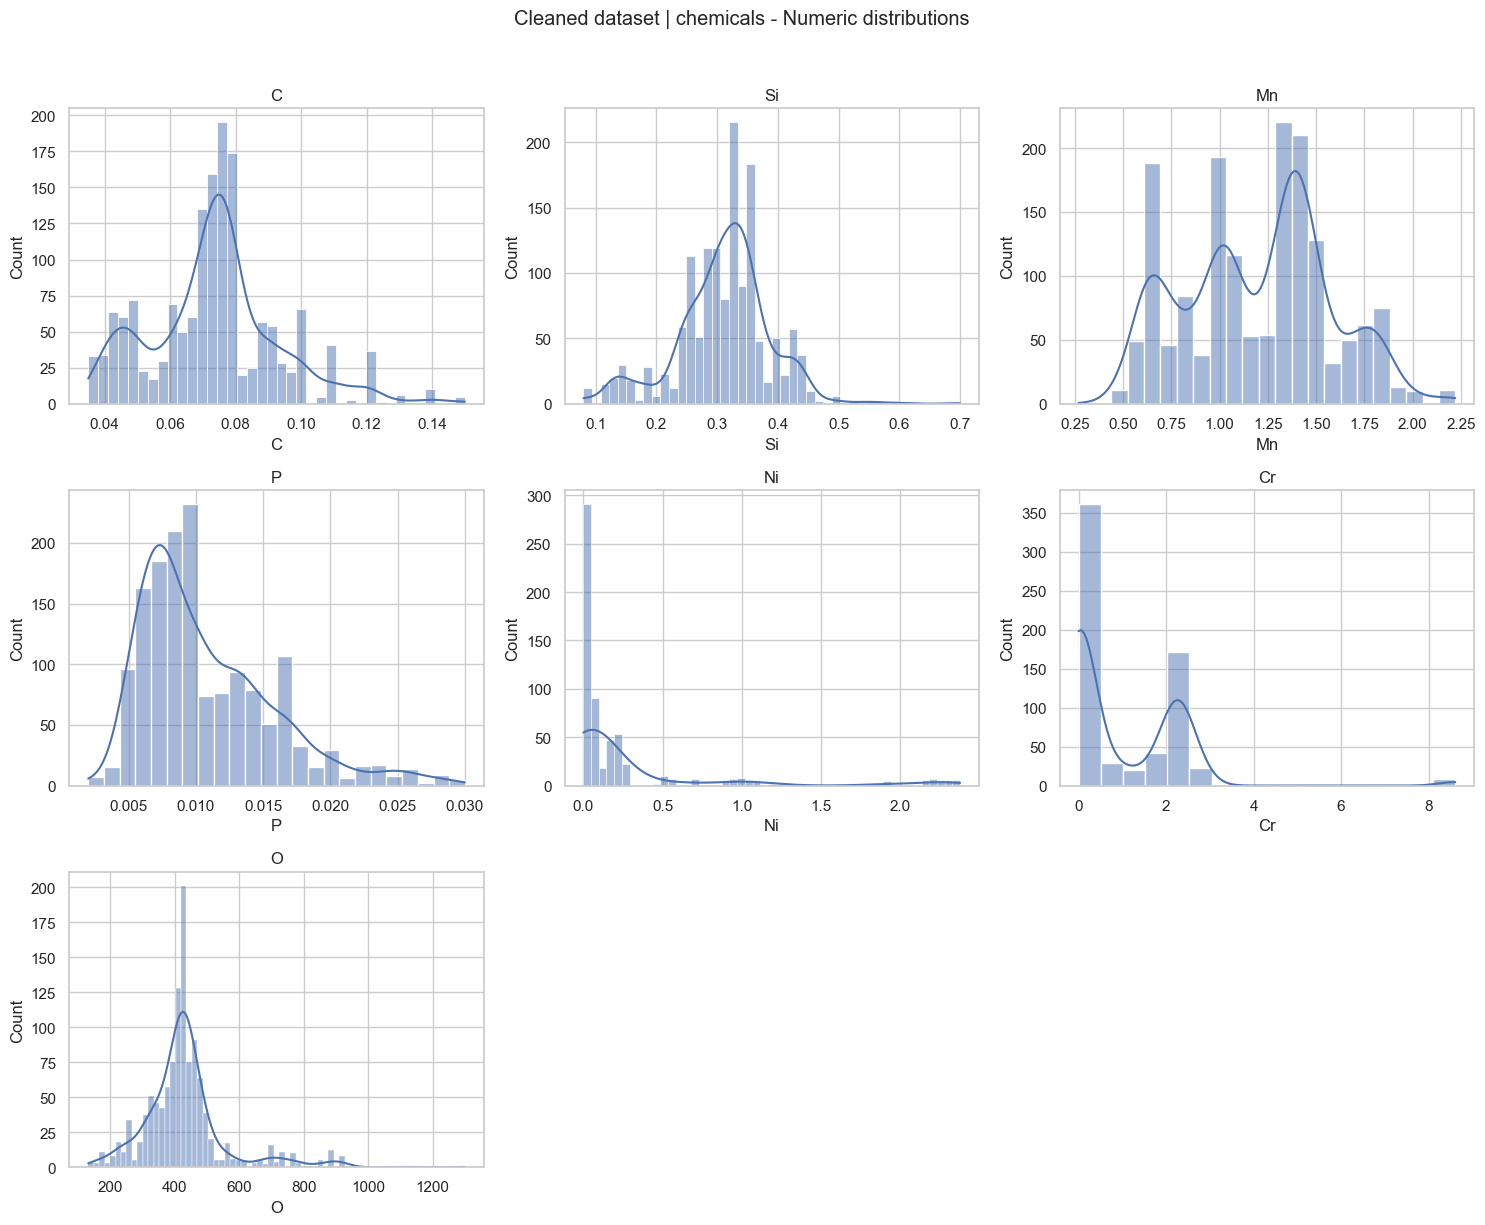

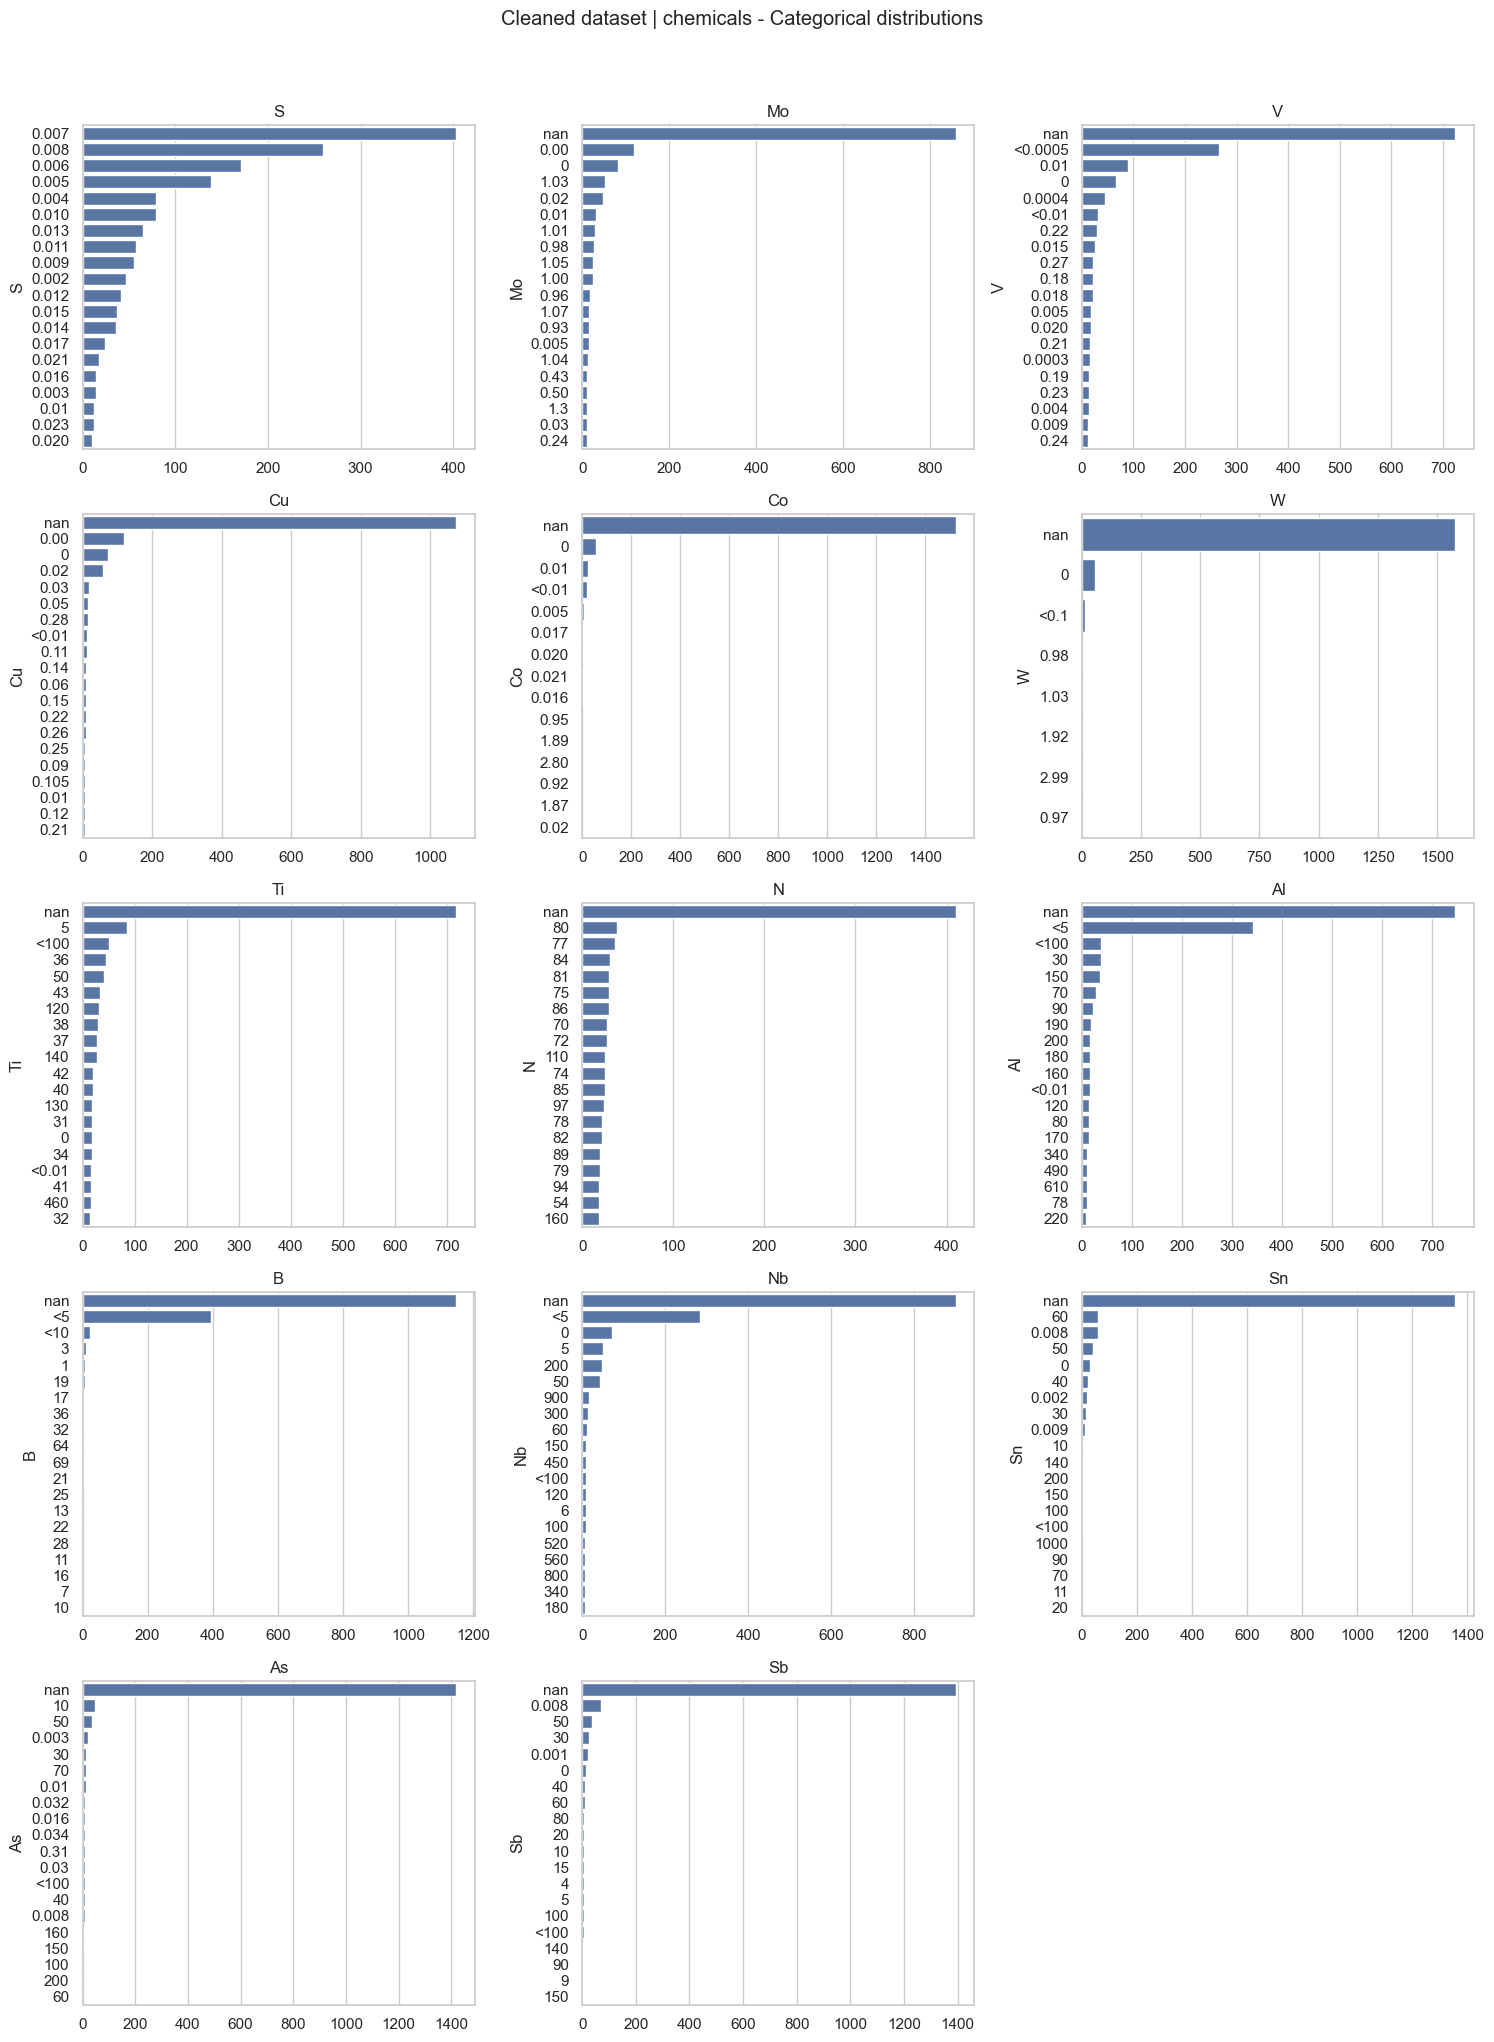

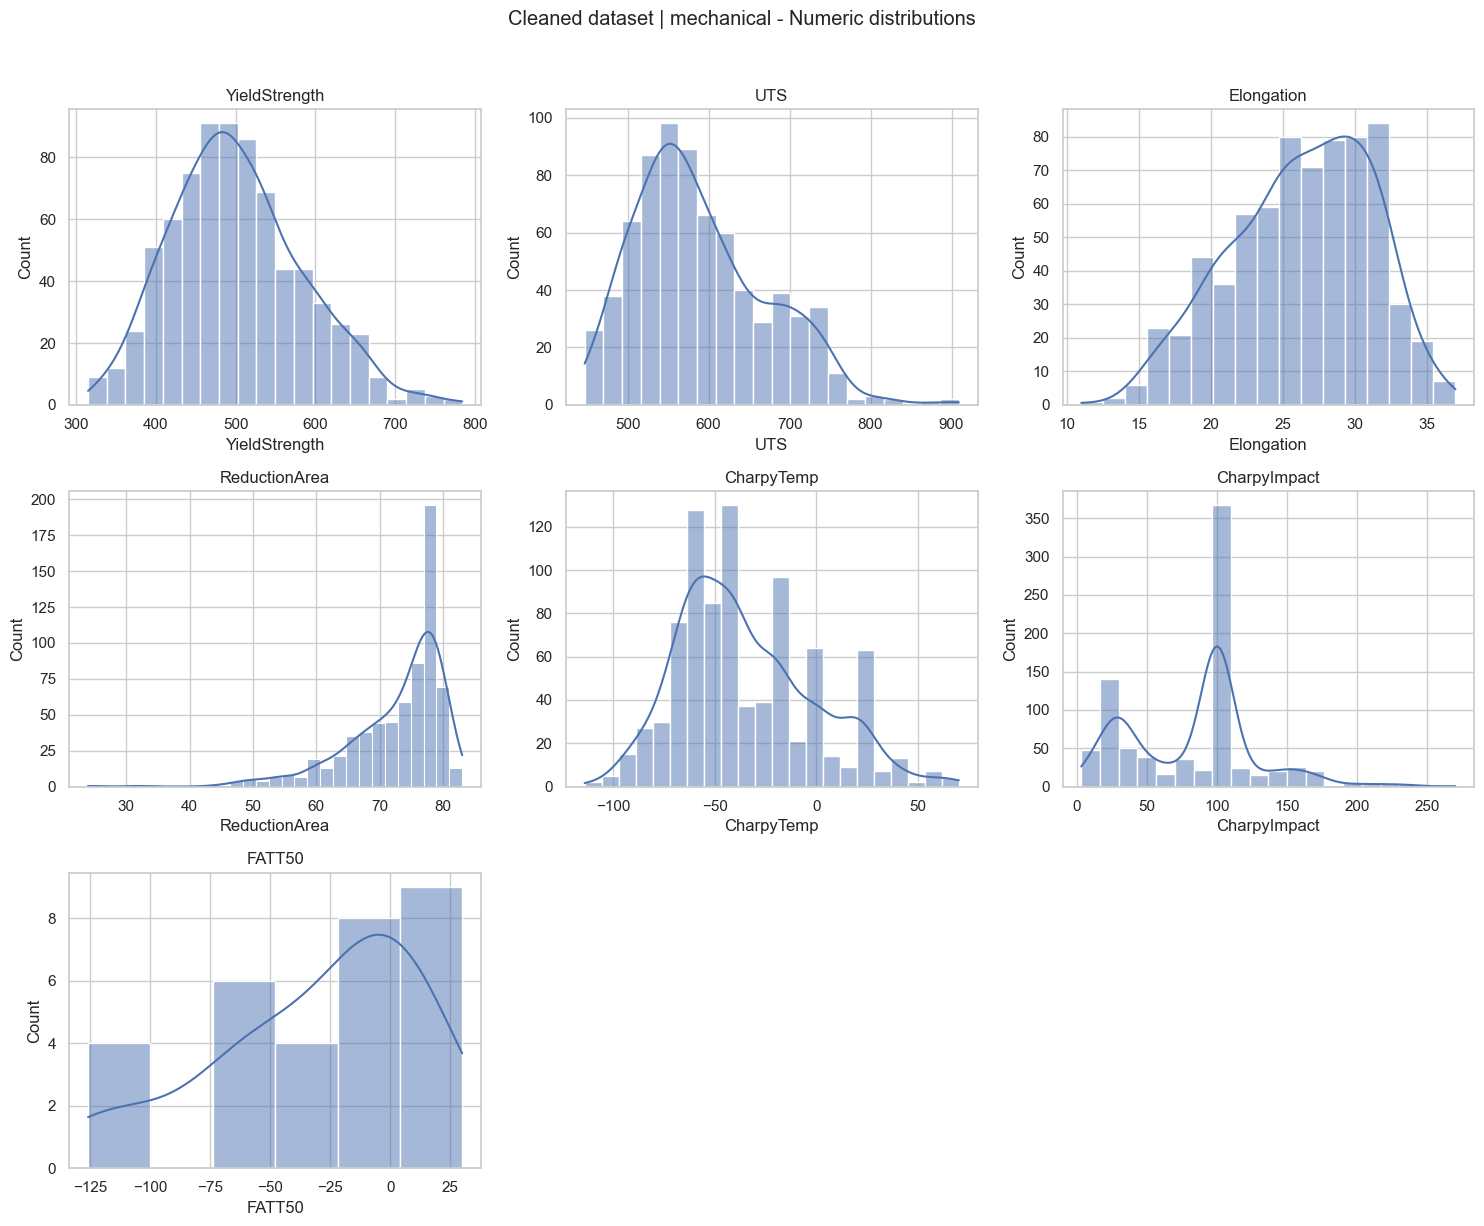

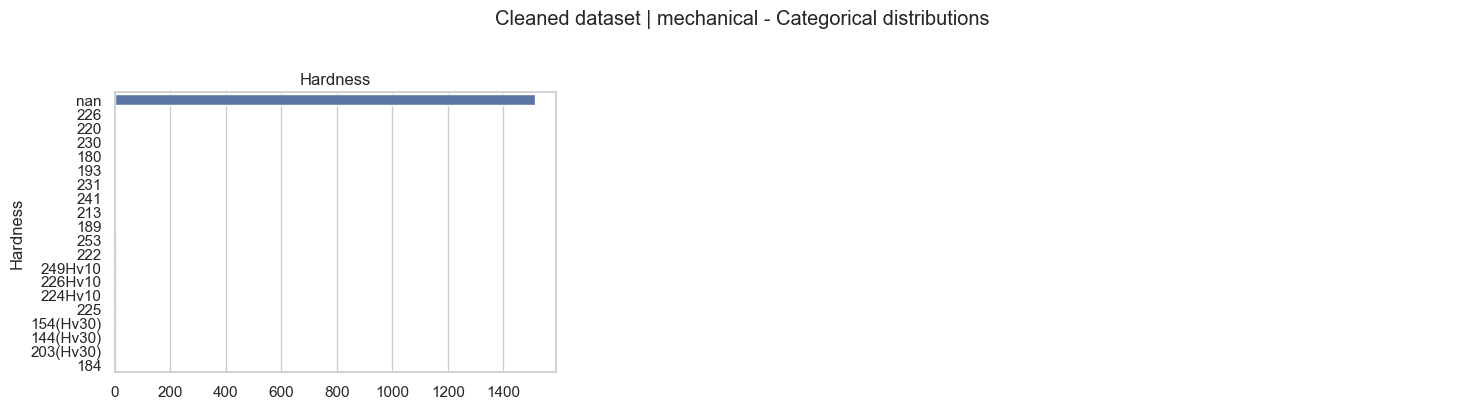

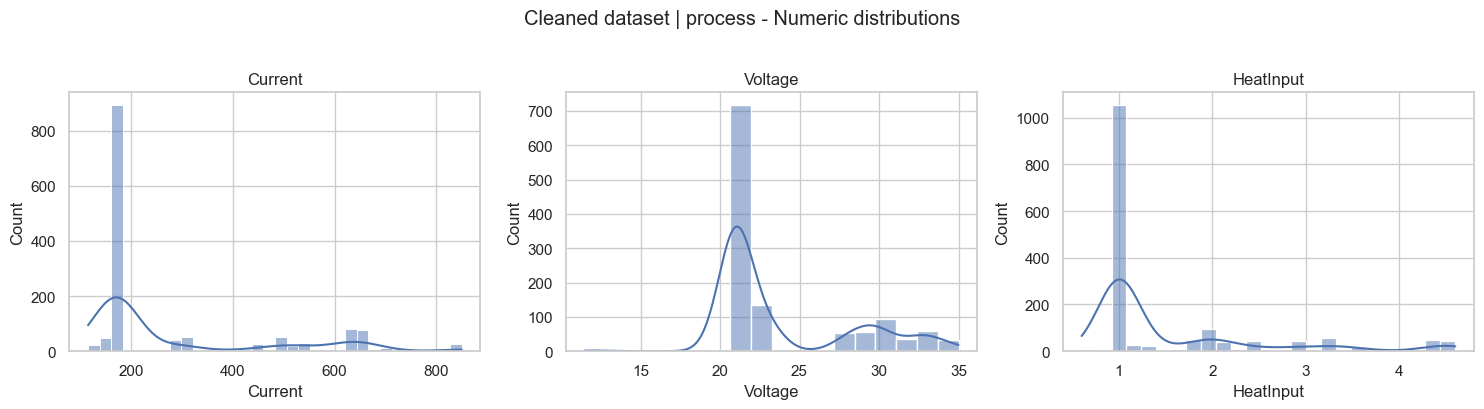

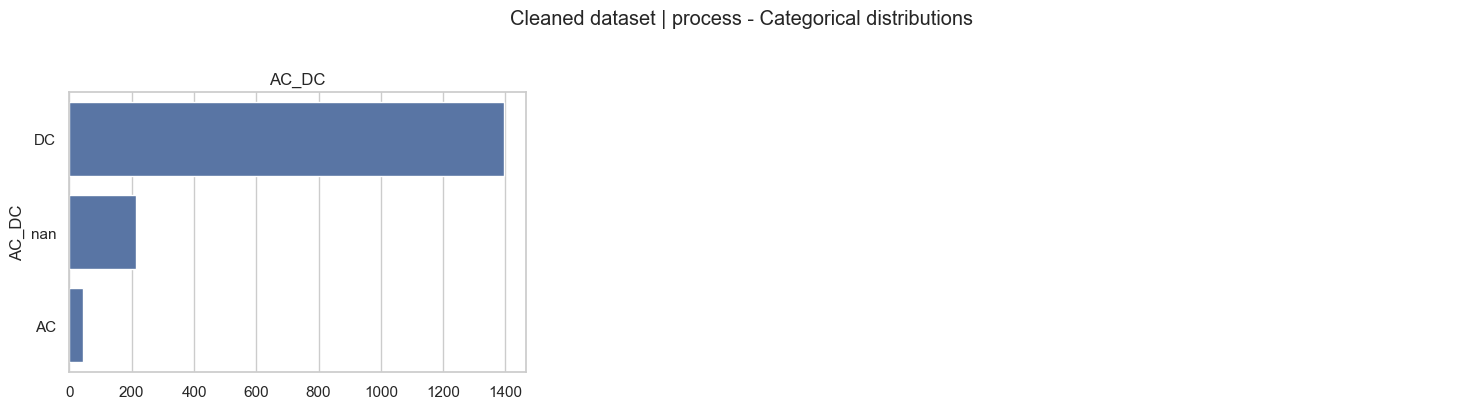

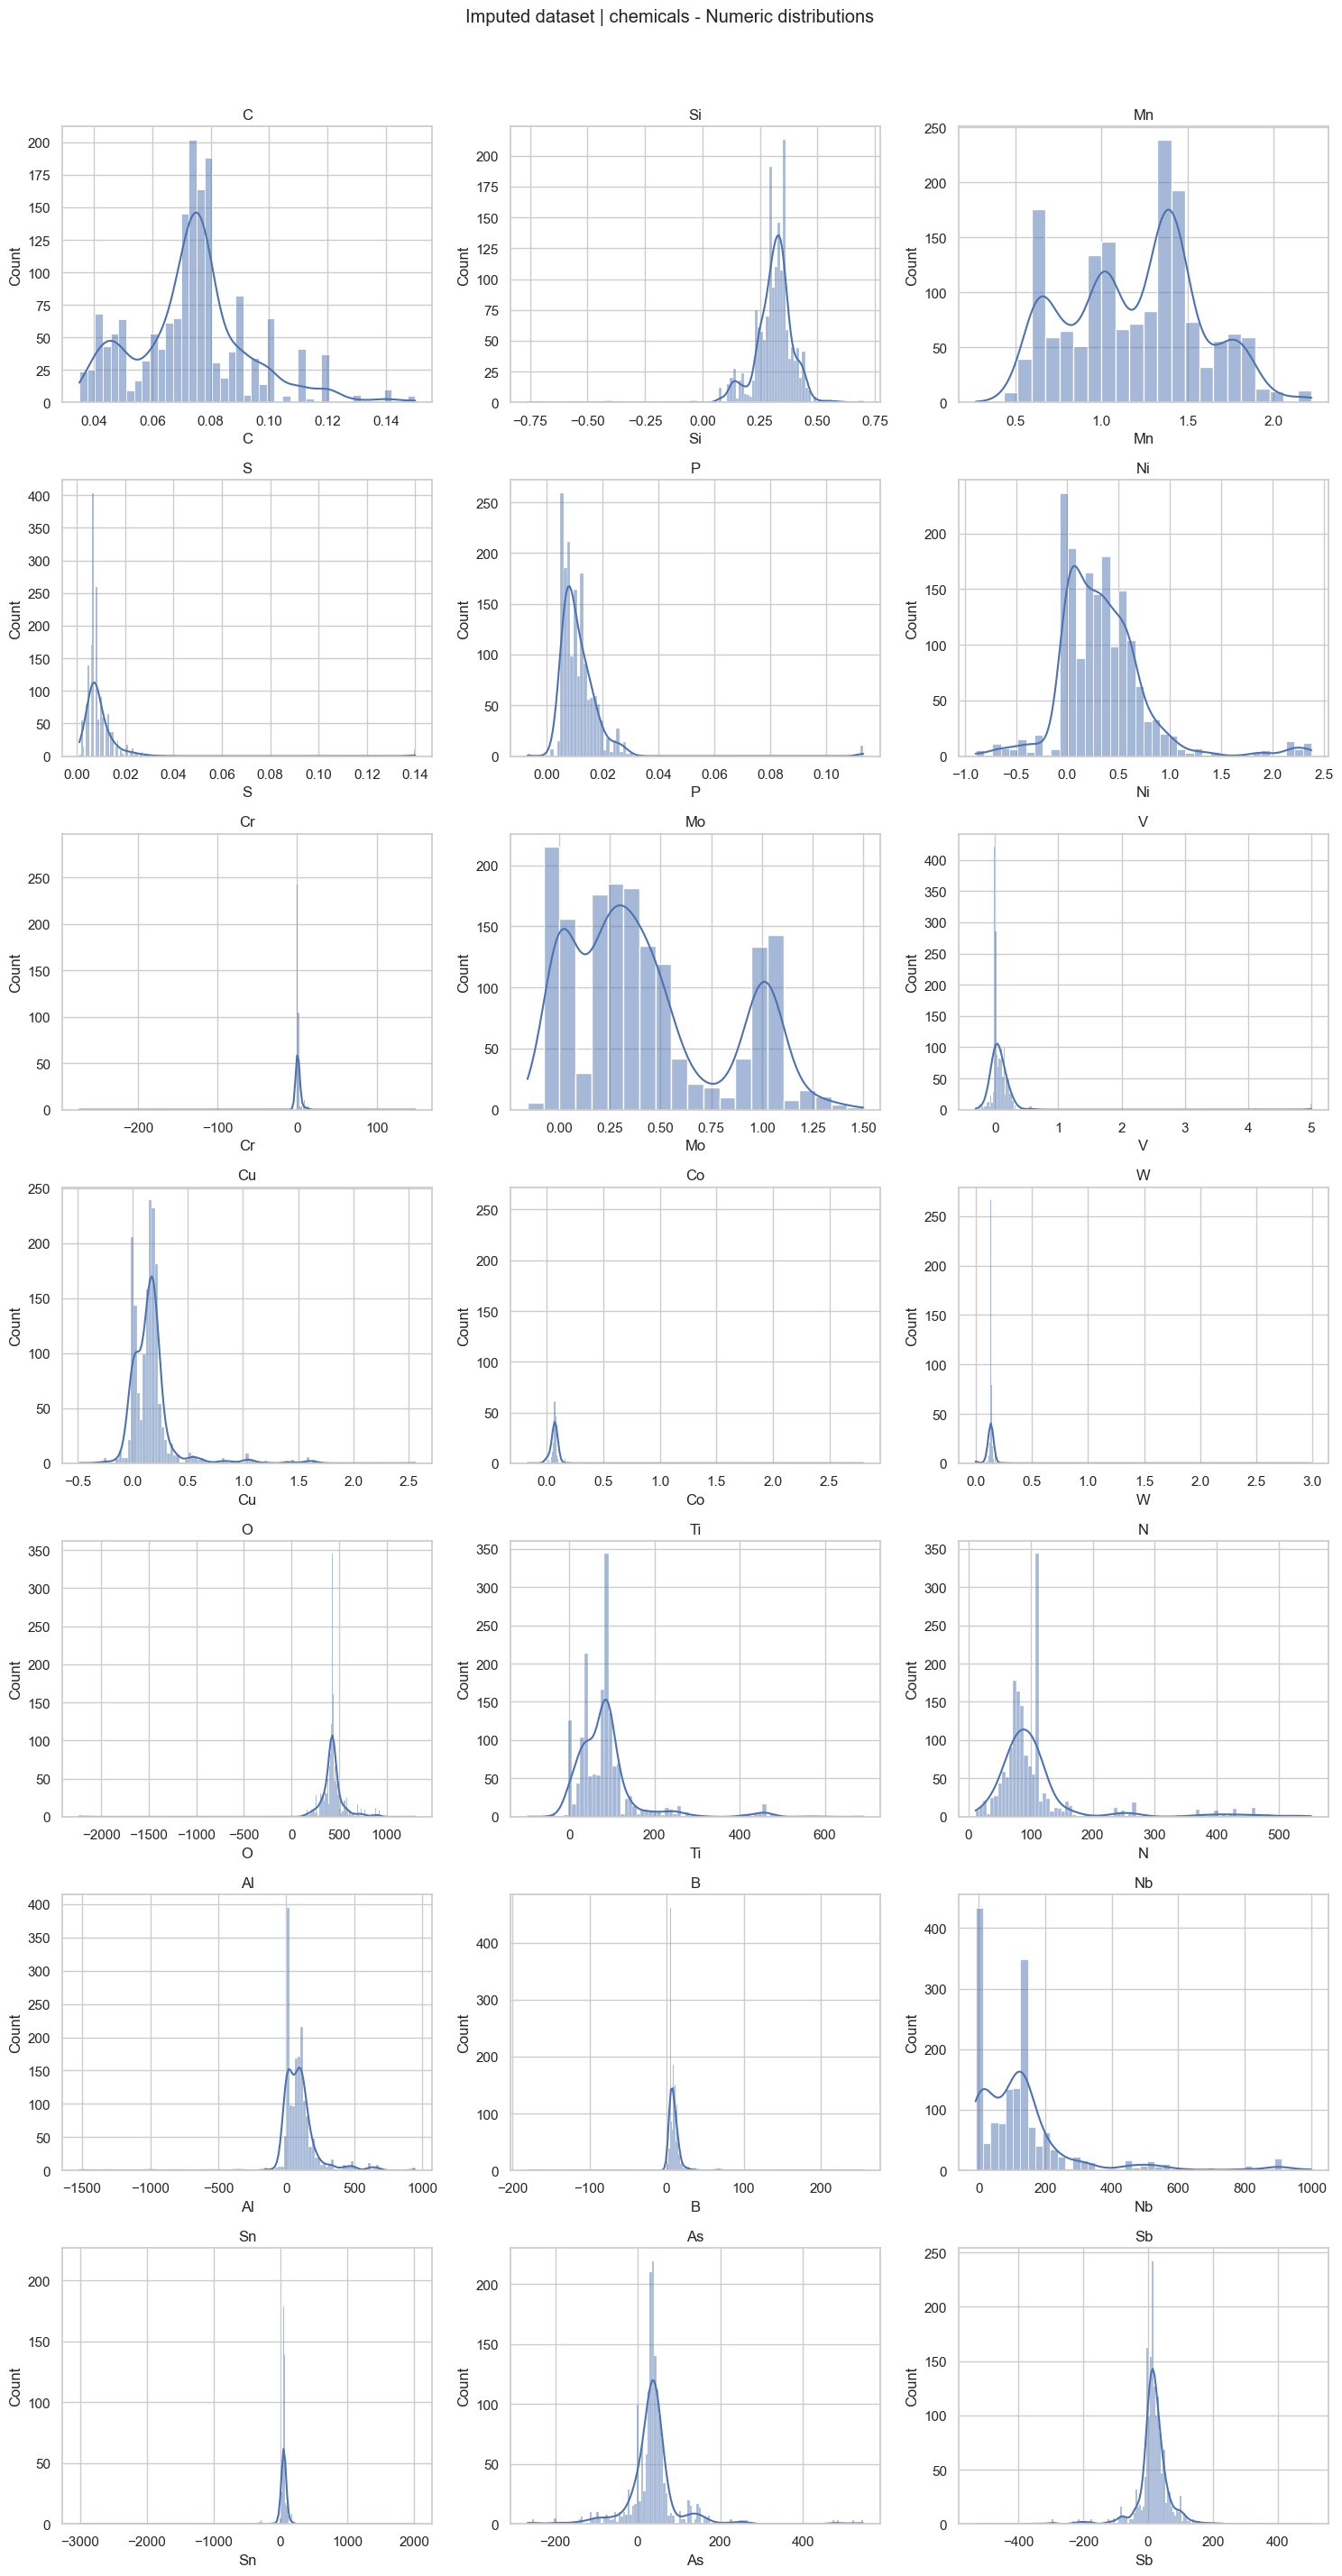

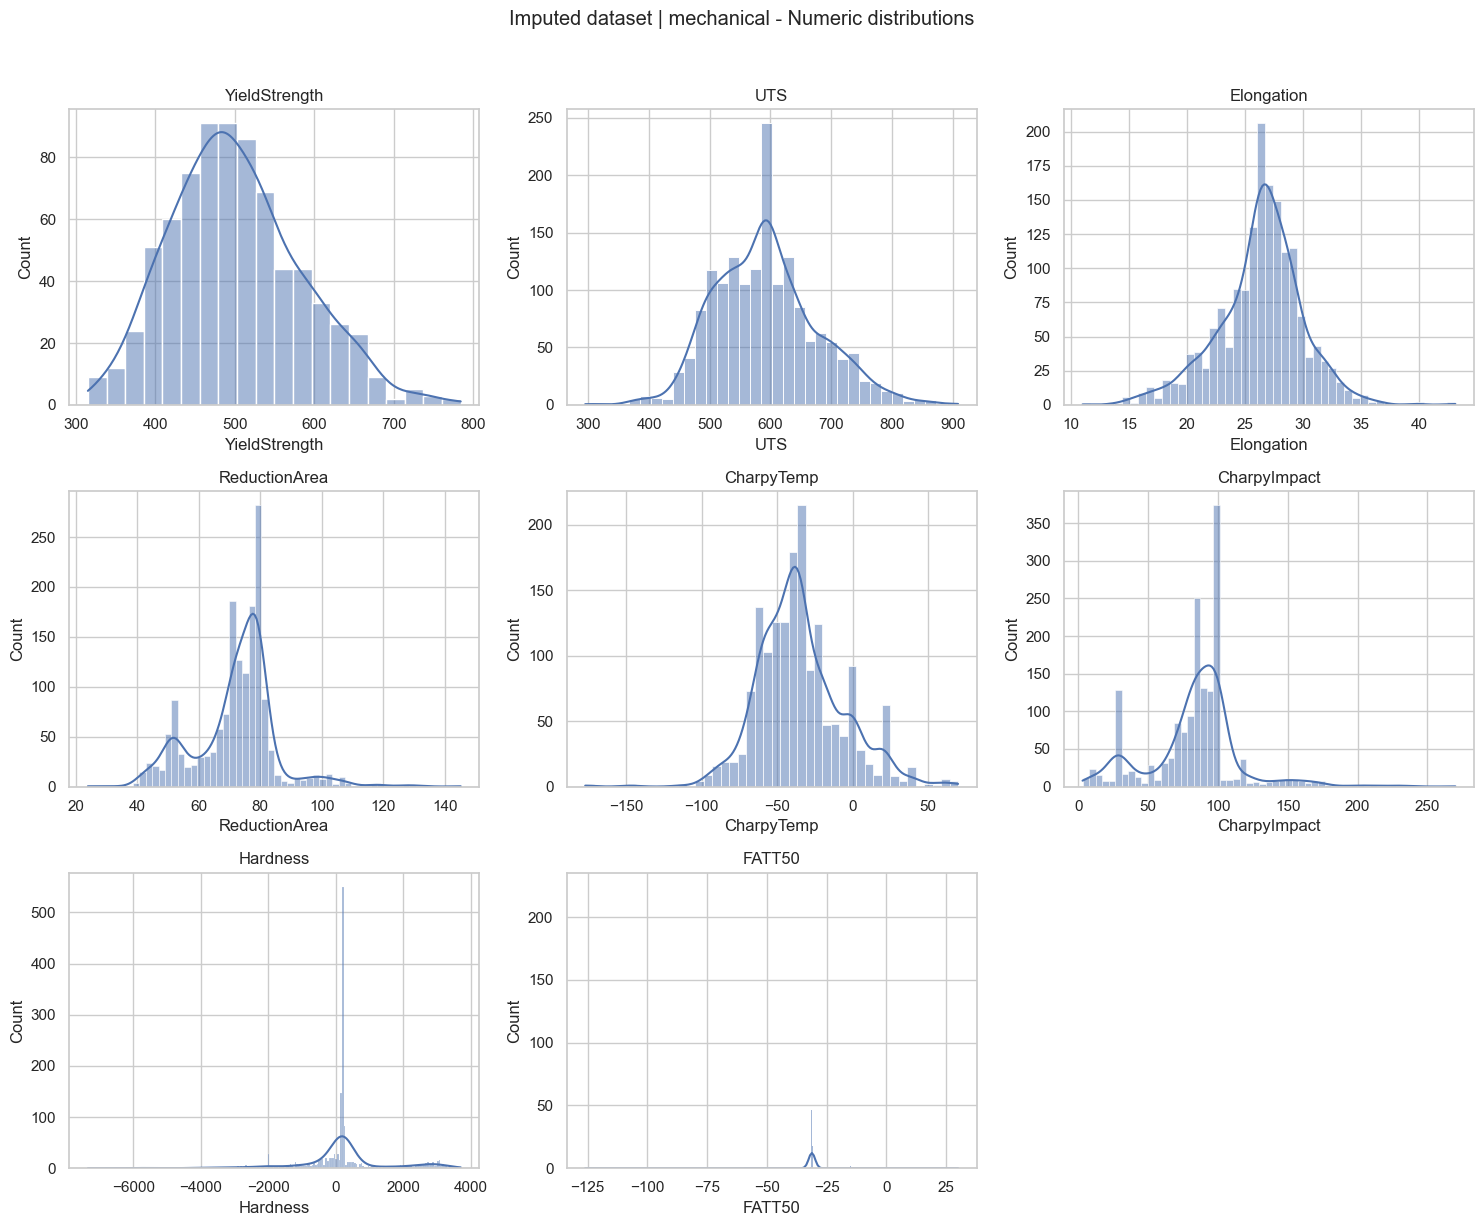

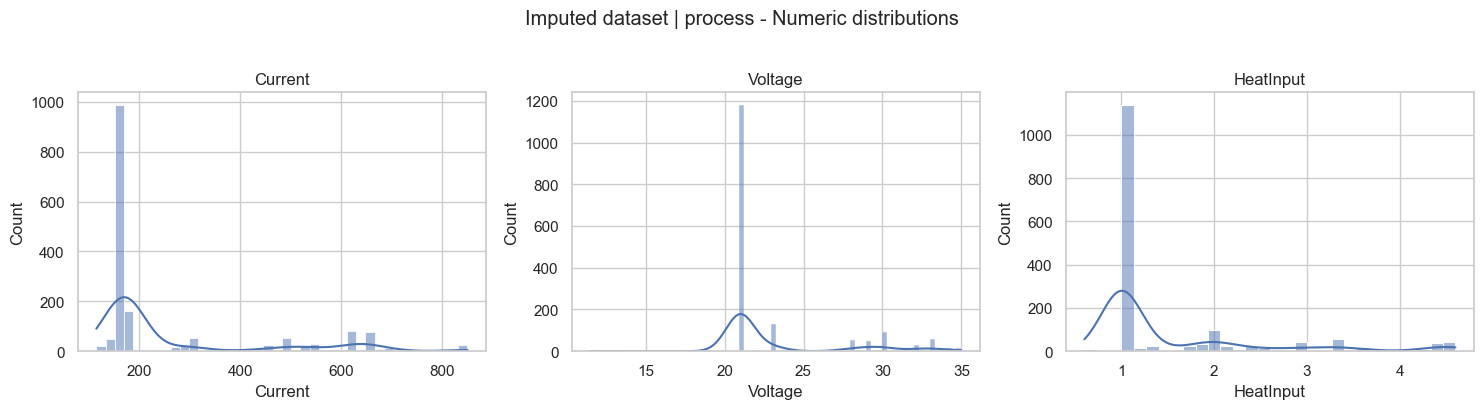

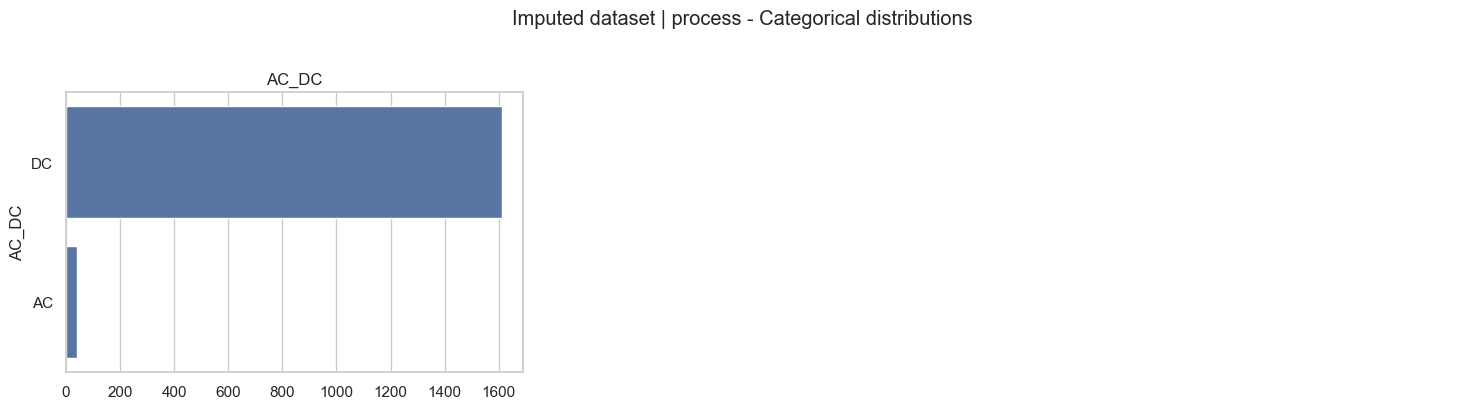

In [4]:
# Plotting helpers for distributions

def plot_numeric_distributions(df: pd.DataFrame, columns: list, title_prefix: str):
    cols = [c for c in columns if c in df.columns]
    if not cols:
        return
    n = len(cols)
    ncols = 3
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))
    axes = np.array(axes).reshape(-1)
    for ax, col in zip(axes, cols):
        sns.histplot(df[col].dropna(), kde=True, ax=ax)
        ax.set_title(col)
    for ax in axes[n:]:
        ax.axis('off')
    fig.suptitle(f"{title_prefix} - Numeric distributions", y=1.02)
    plt.tight_layout()
    plt.show()


def plot_categorical_distributions(df: pd.DataFrame, columns: list, title_prefix: str, top_k: int = 20):
    cols = [c for c in columns if c in df.columns]
    if not cols:
        return
    n = len(cols)
    ncols = 3
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))
    axes = np.array(axes).reshape(-1)
    for ax, col in zip(axes, cols):
        counts = df[col].astype(str).value_counts(dropna=False).head(top_k)
        sns.barplot(x=counts.values, y=counts.index, ax=ax)
        ax.set_title(col)
    for ax in axes[n:]:
        ax.axis('off')
    fig.suptitle(f"{title_prefix} - Categorical distributions", y=1.02)
    plt.tight_layout()
    plt.show()

# Run per dataset and group
def run_distribution_plots(df: pd.DataFrame, groups: dict, title: str):
    categorical, numeric = detect_types(df)
    for gname, gcols in groups.items():
        num_cols = [c for c in gcols if c in numeric]
        cat_cols = [c for c in gcols if c in categorical]
        if num_cols:
            plot_numeric_distributions(df, num_cols, f"{title} | {gname}")
        if cat_cols:
            plot_categorical_distributions(df, cat_cols, f"{title} | {gname}")

run_distribution_plots(df_clean, GROUPS_CLEAN, "Cleaned dataset")
run_distribution_plots(df_imputed, GROUPS_IMPUTED, "Imputed dataset")


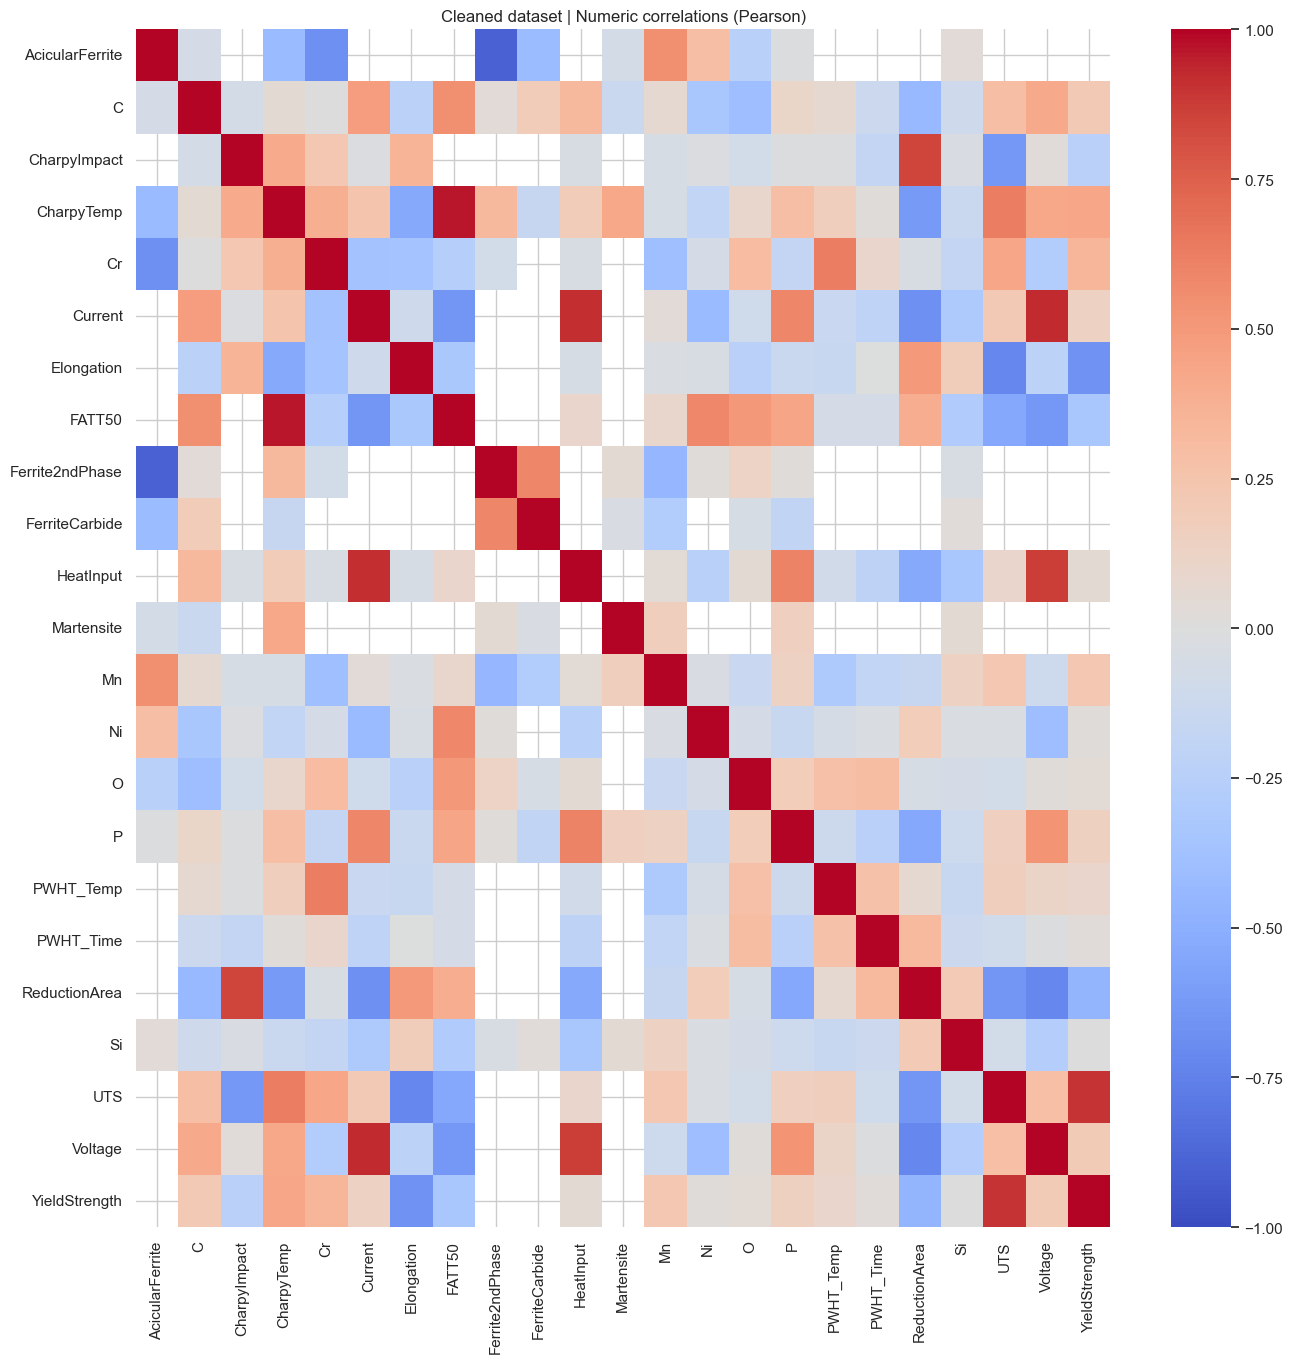

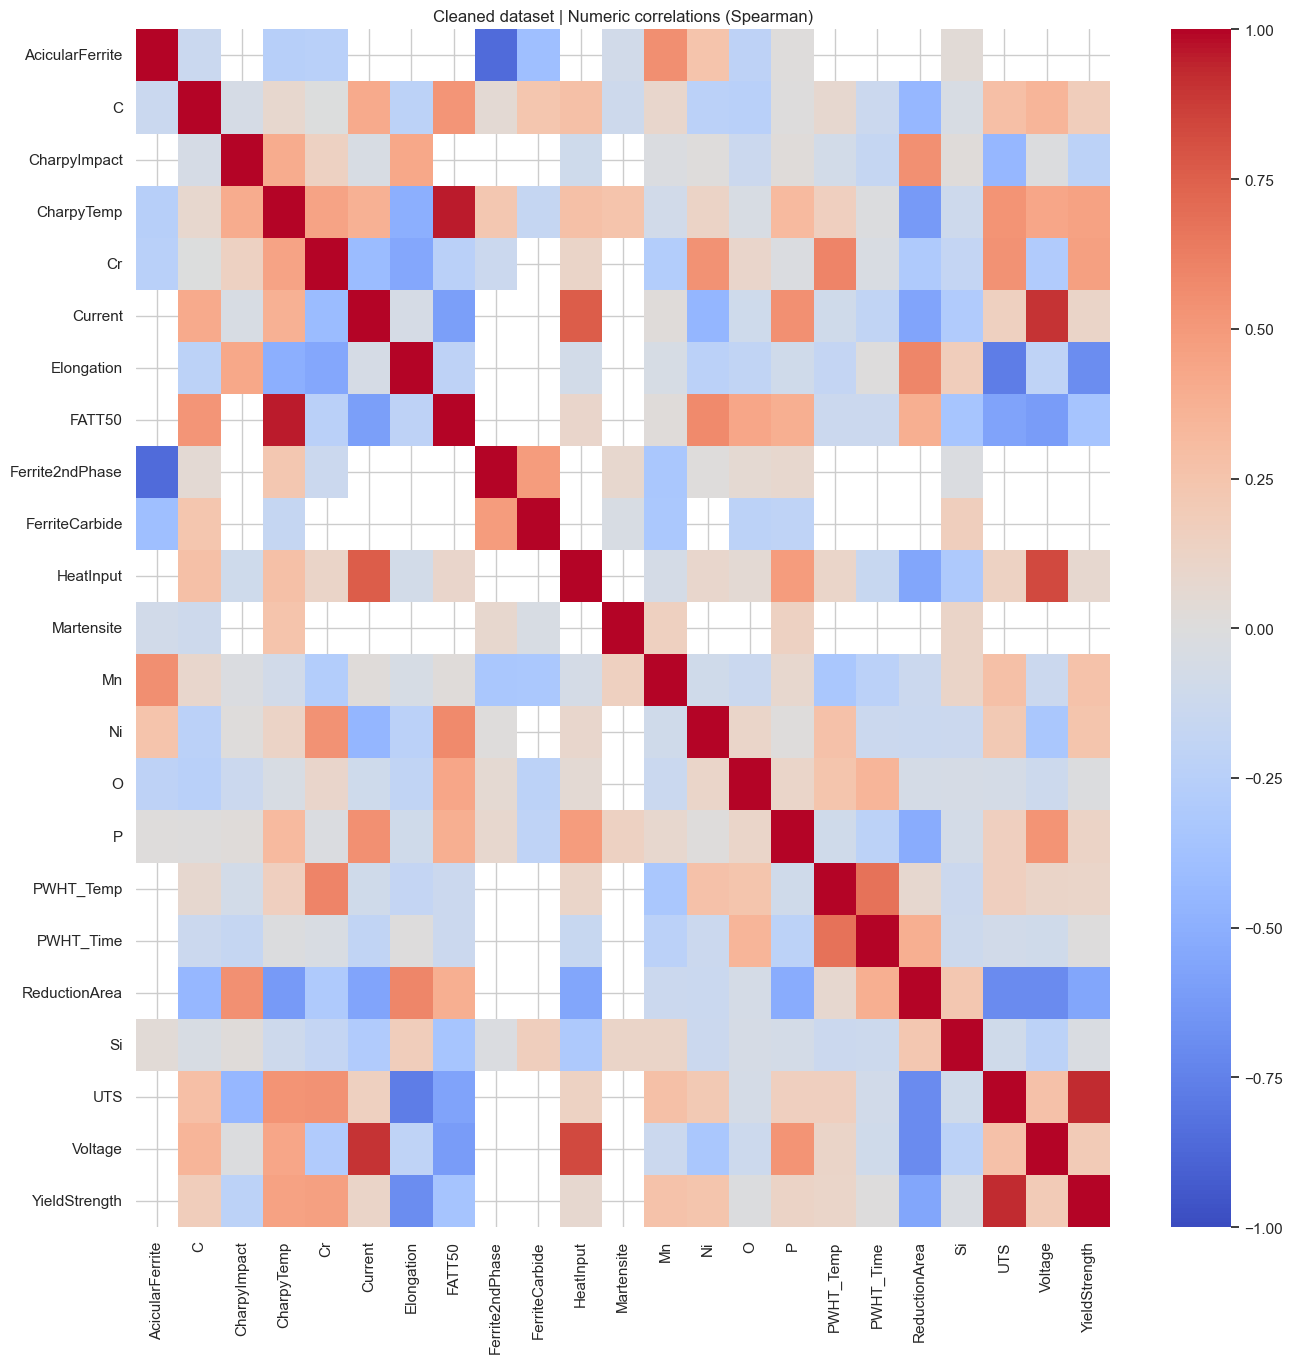

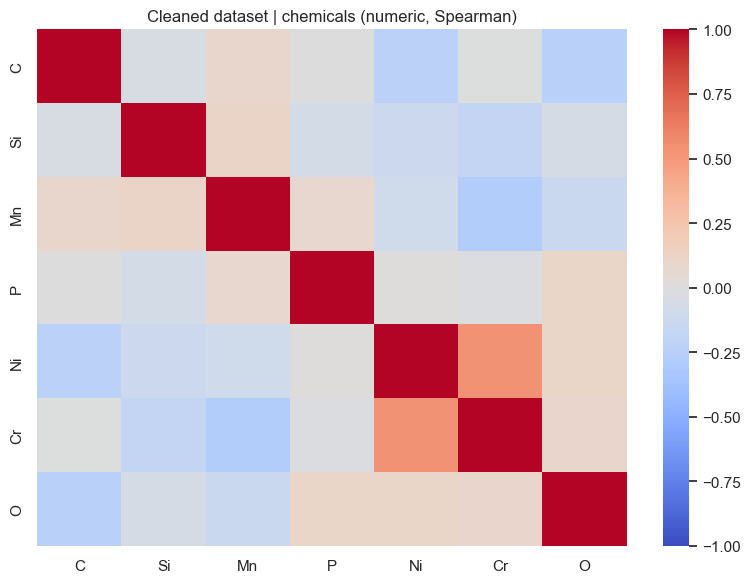

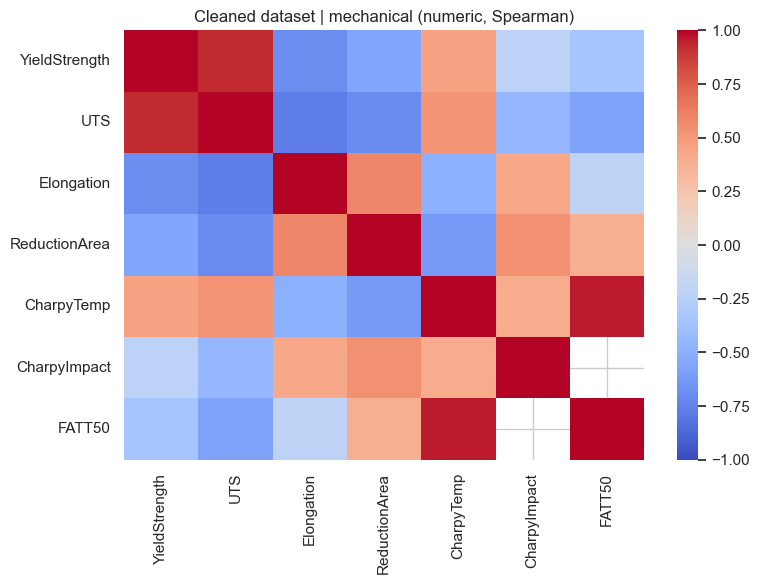

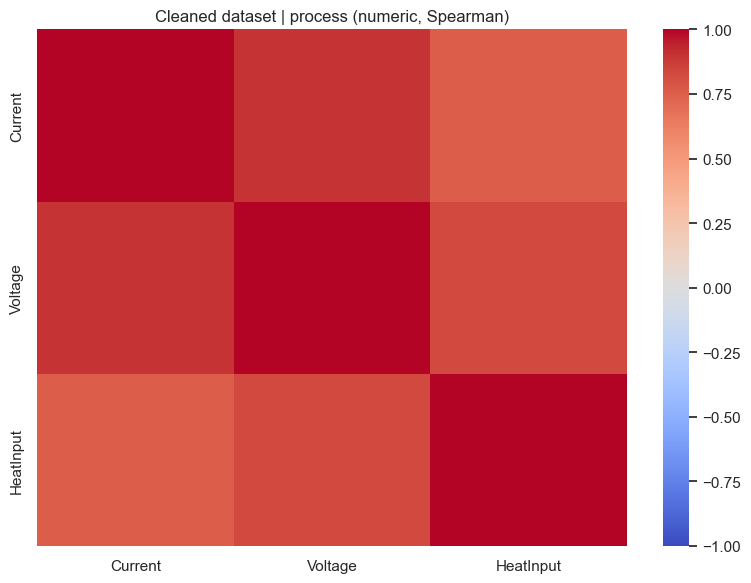

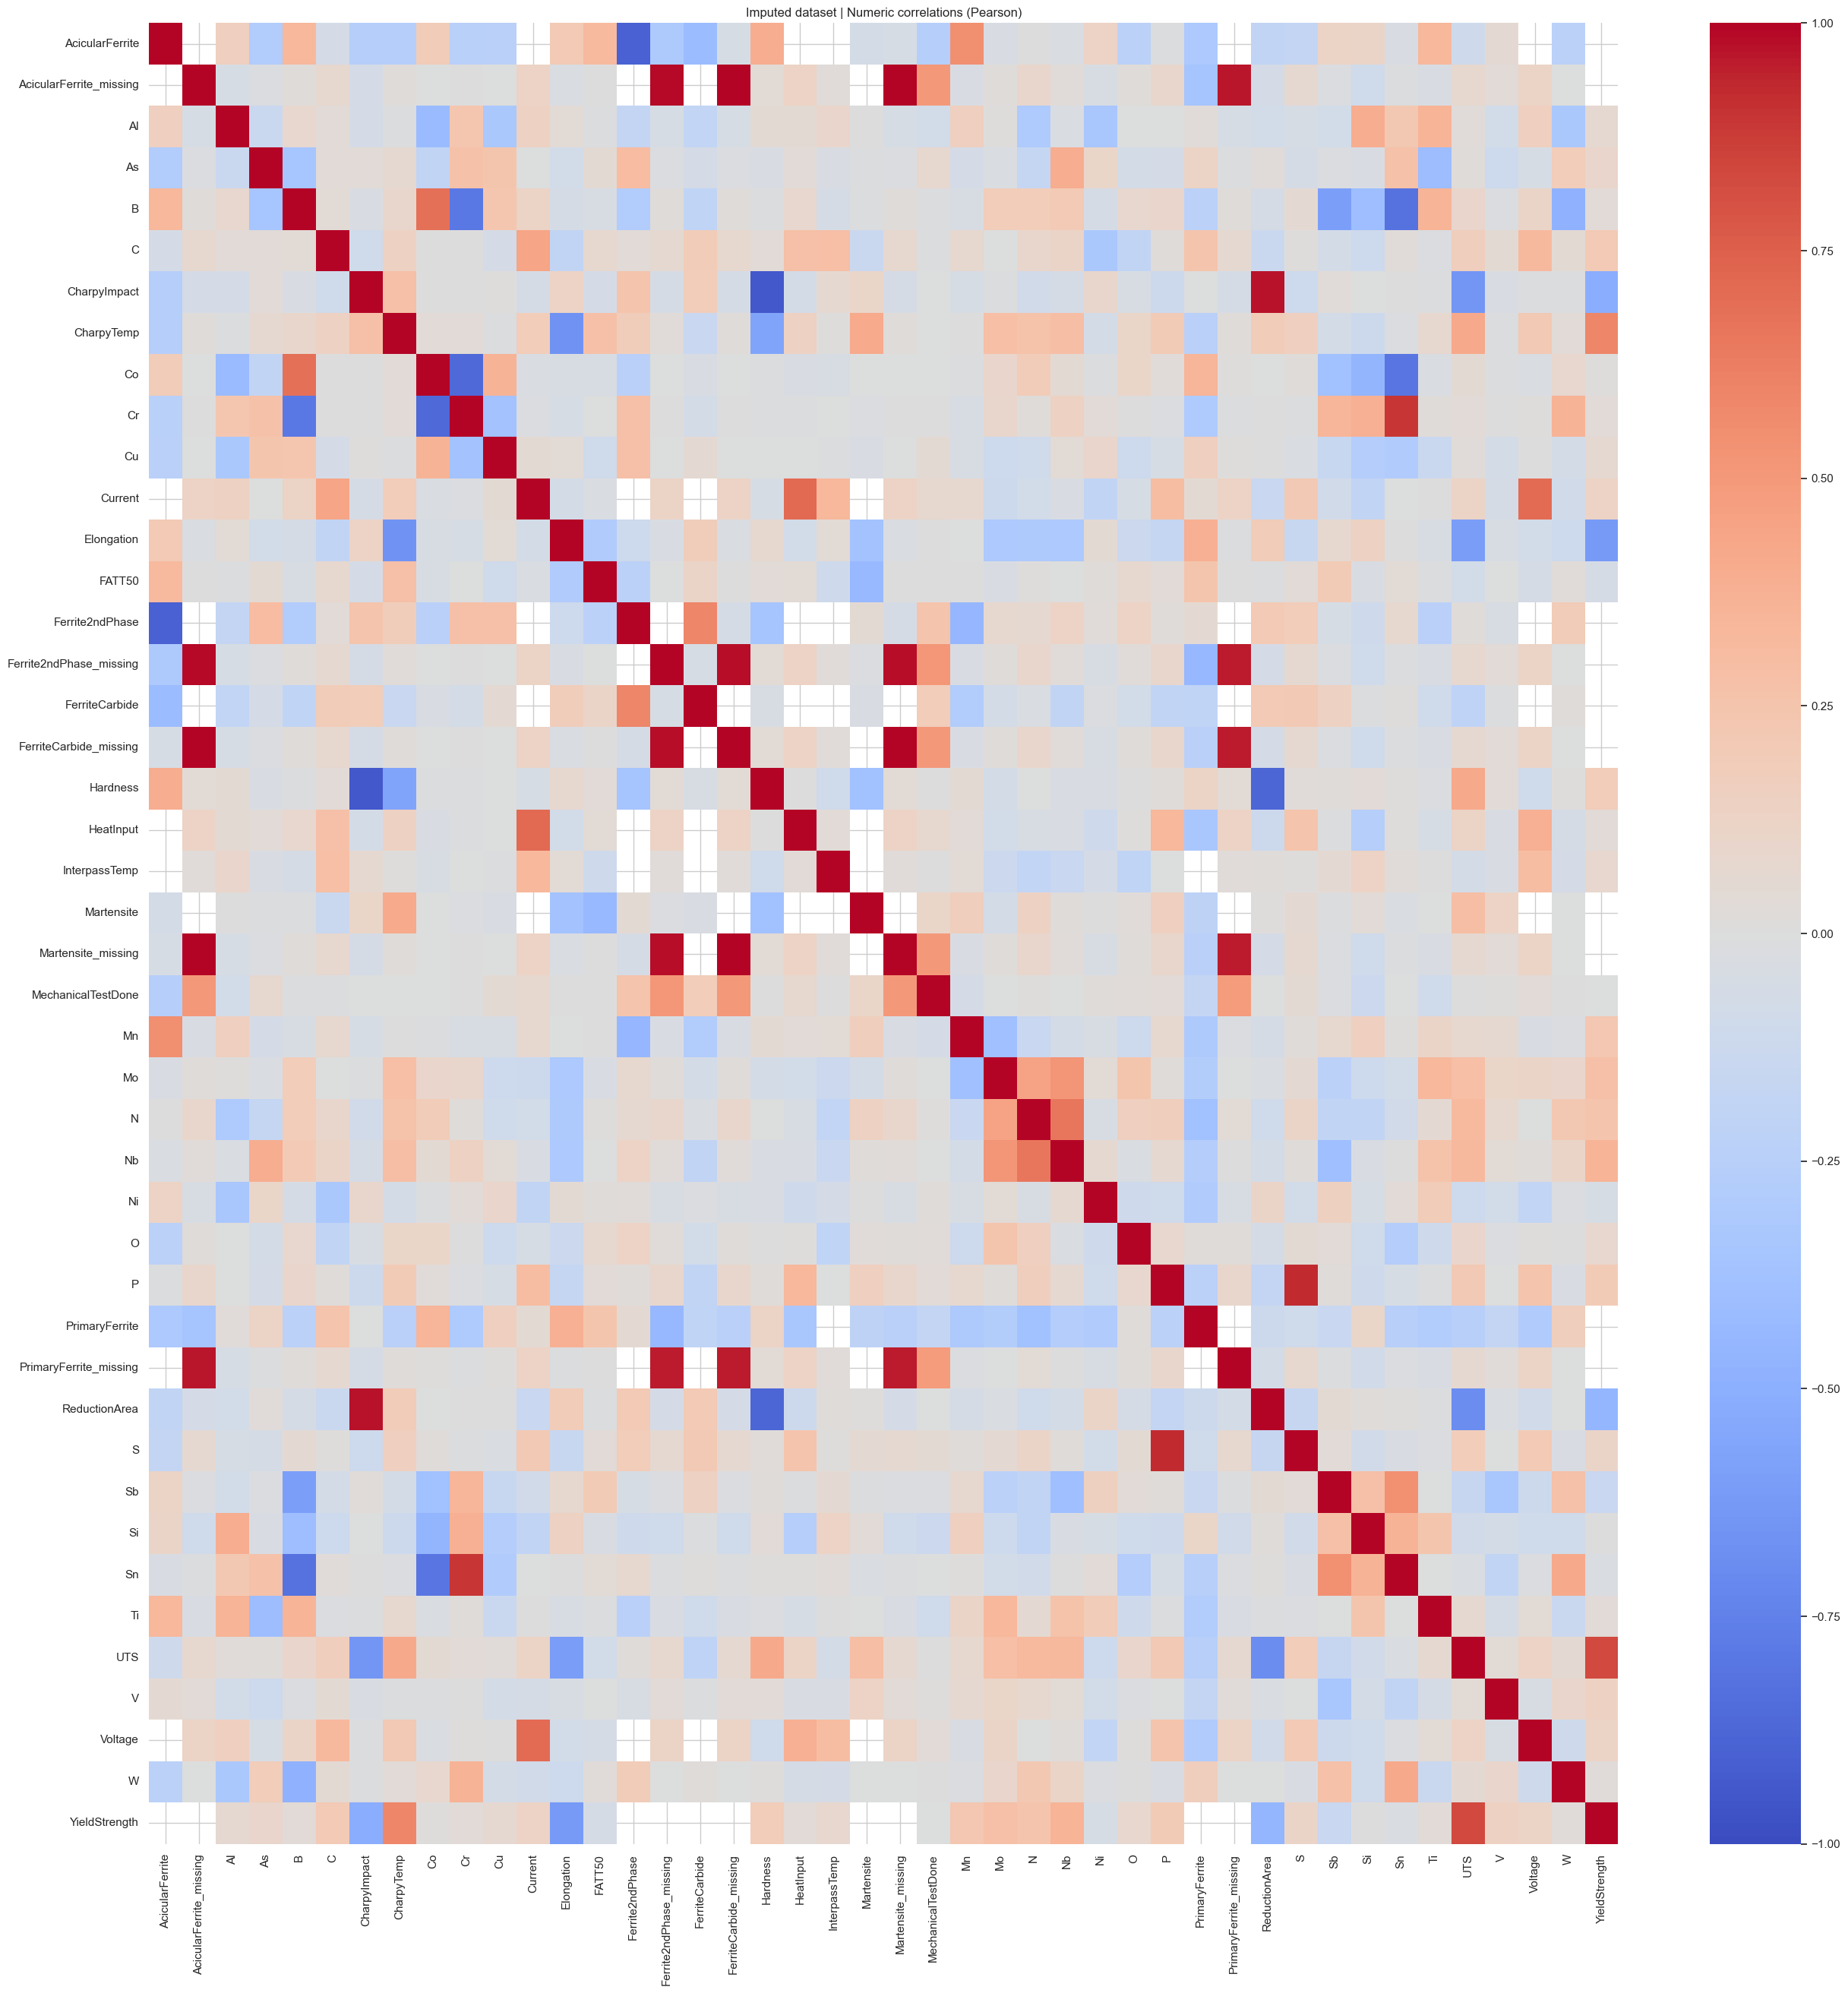

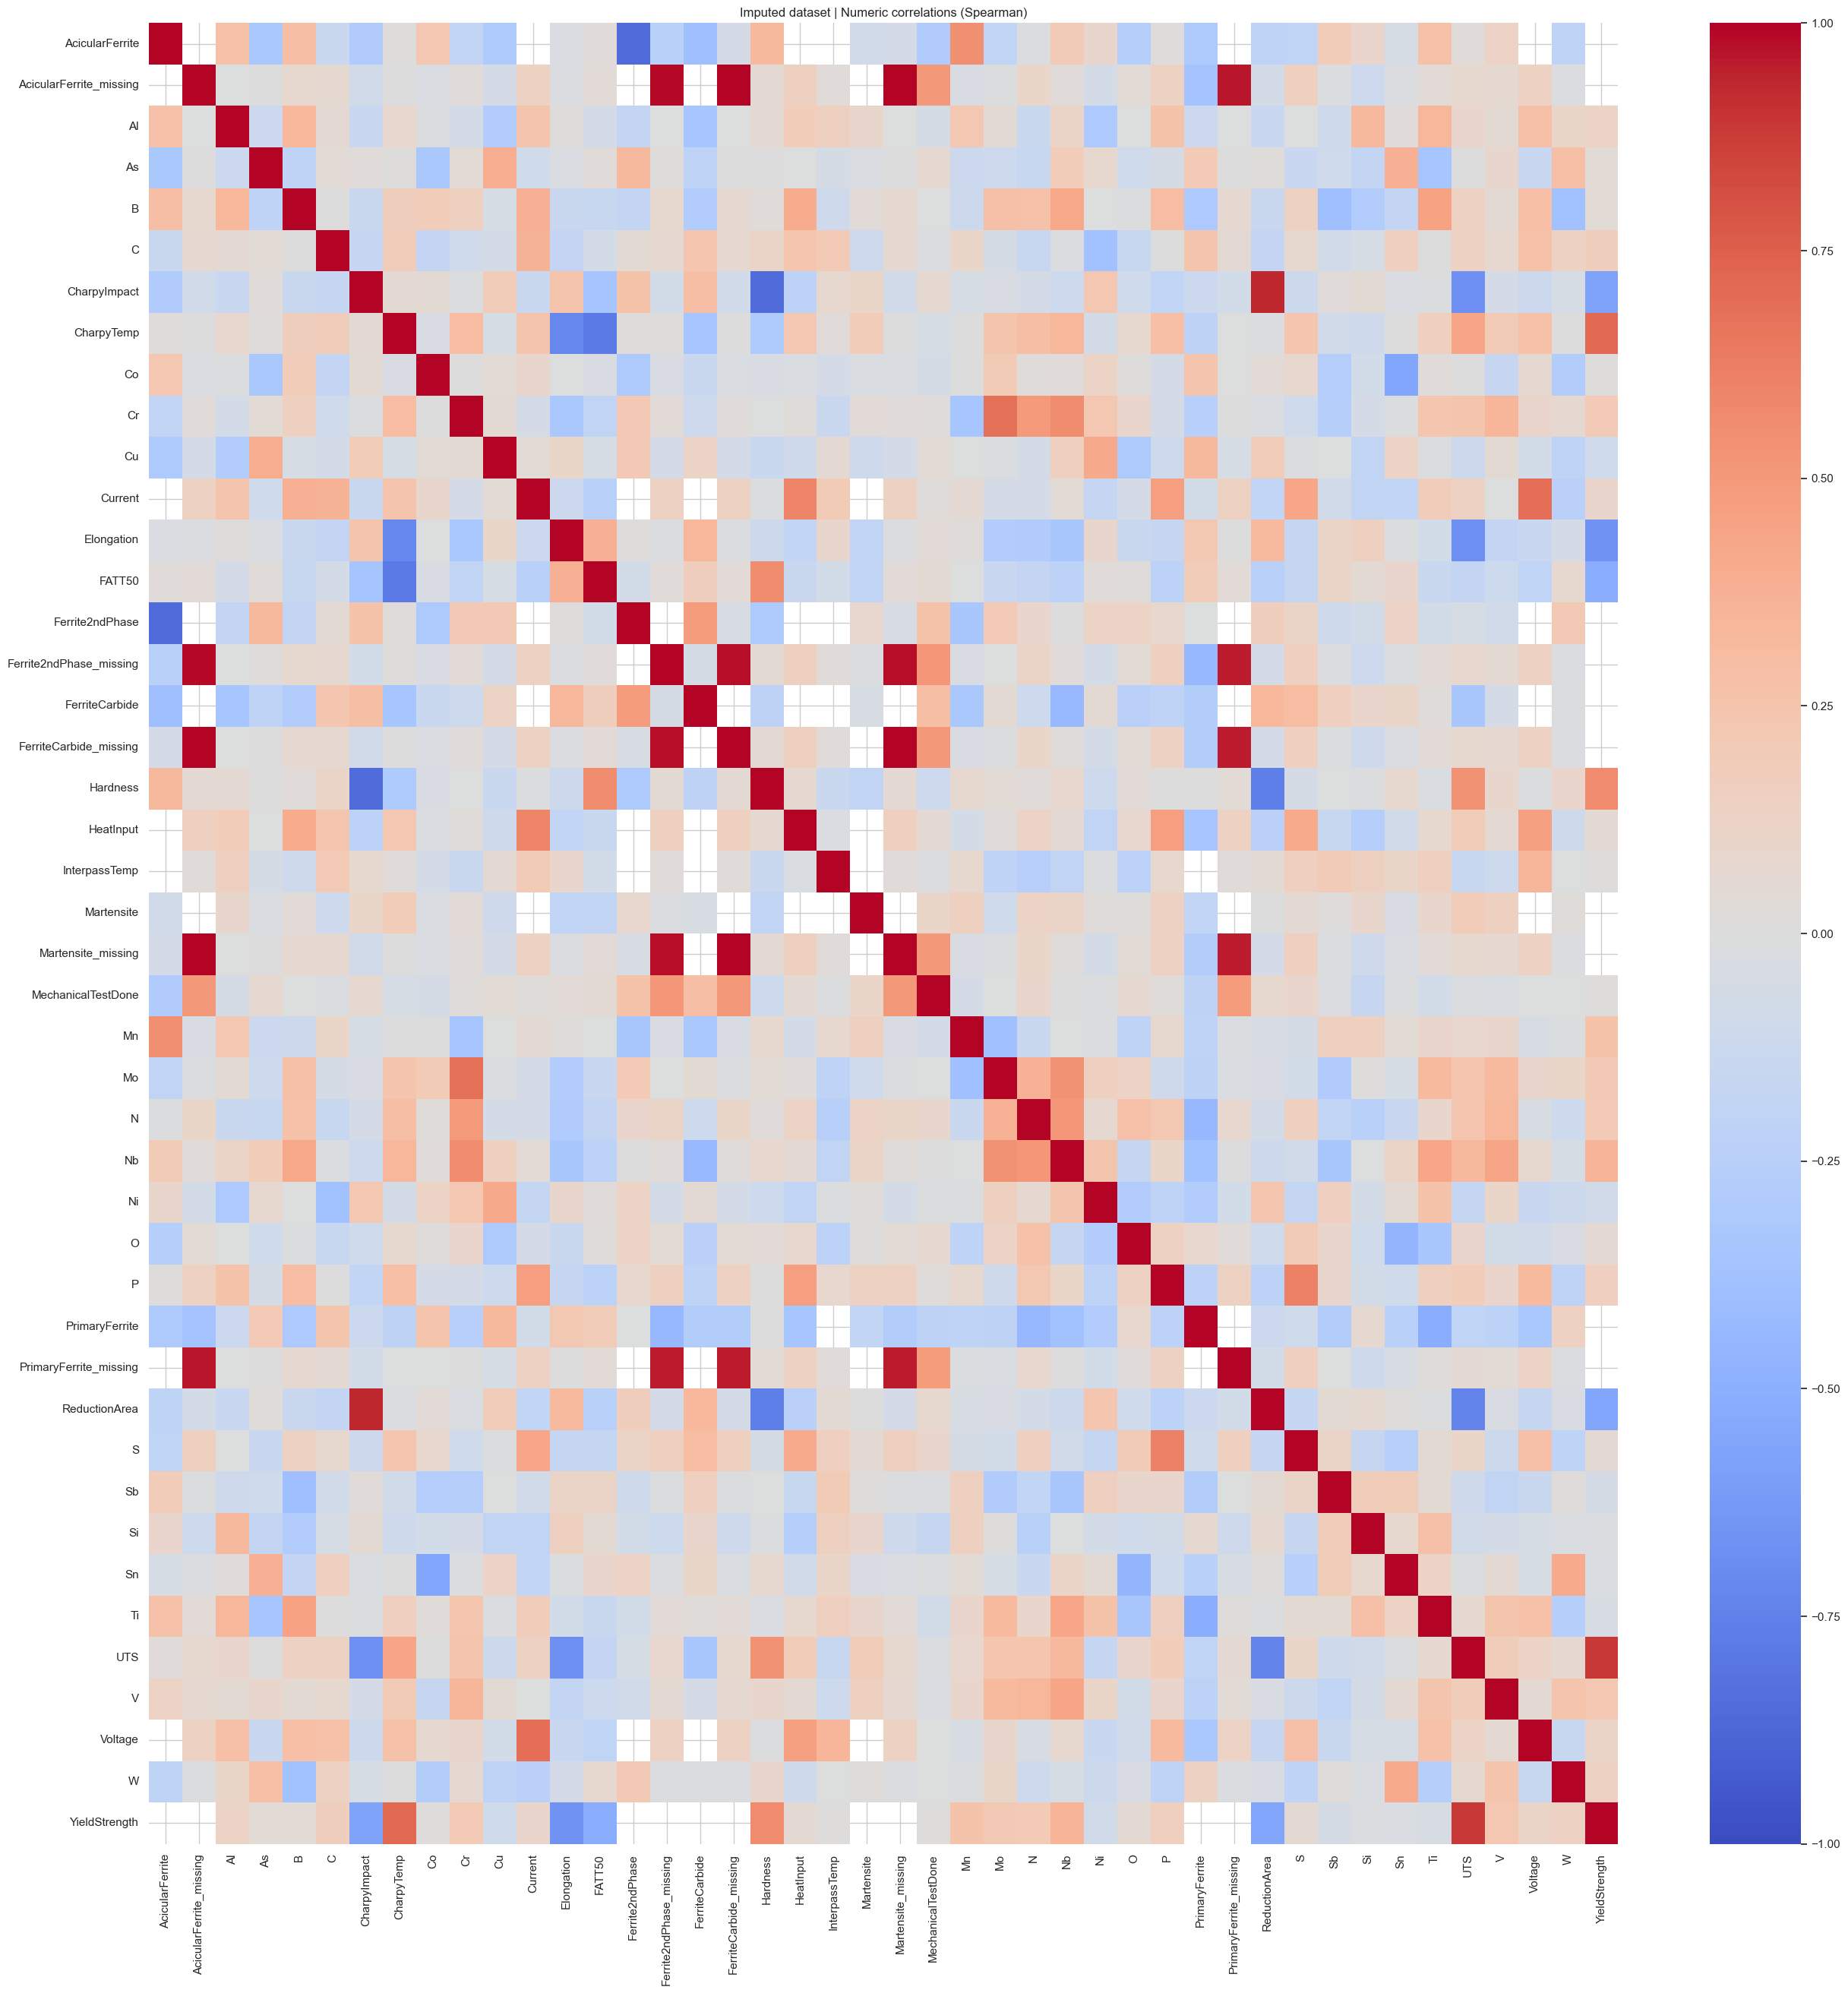

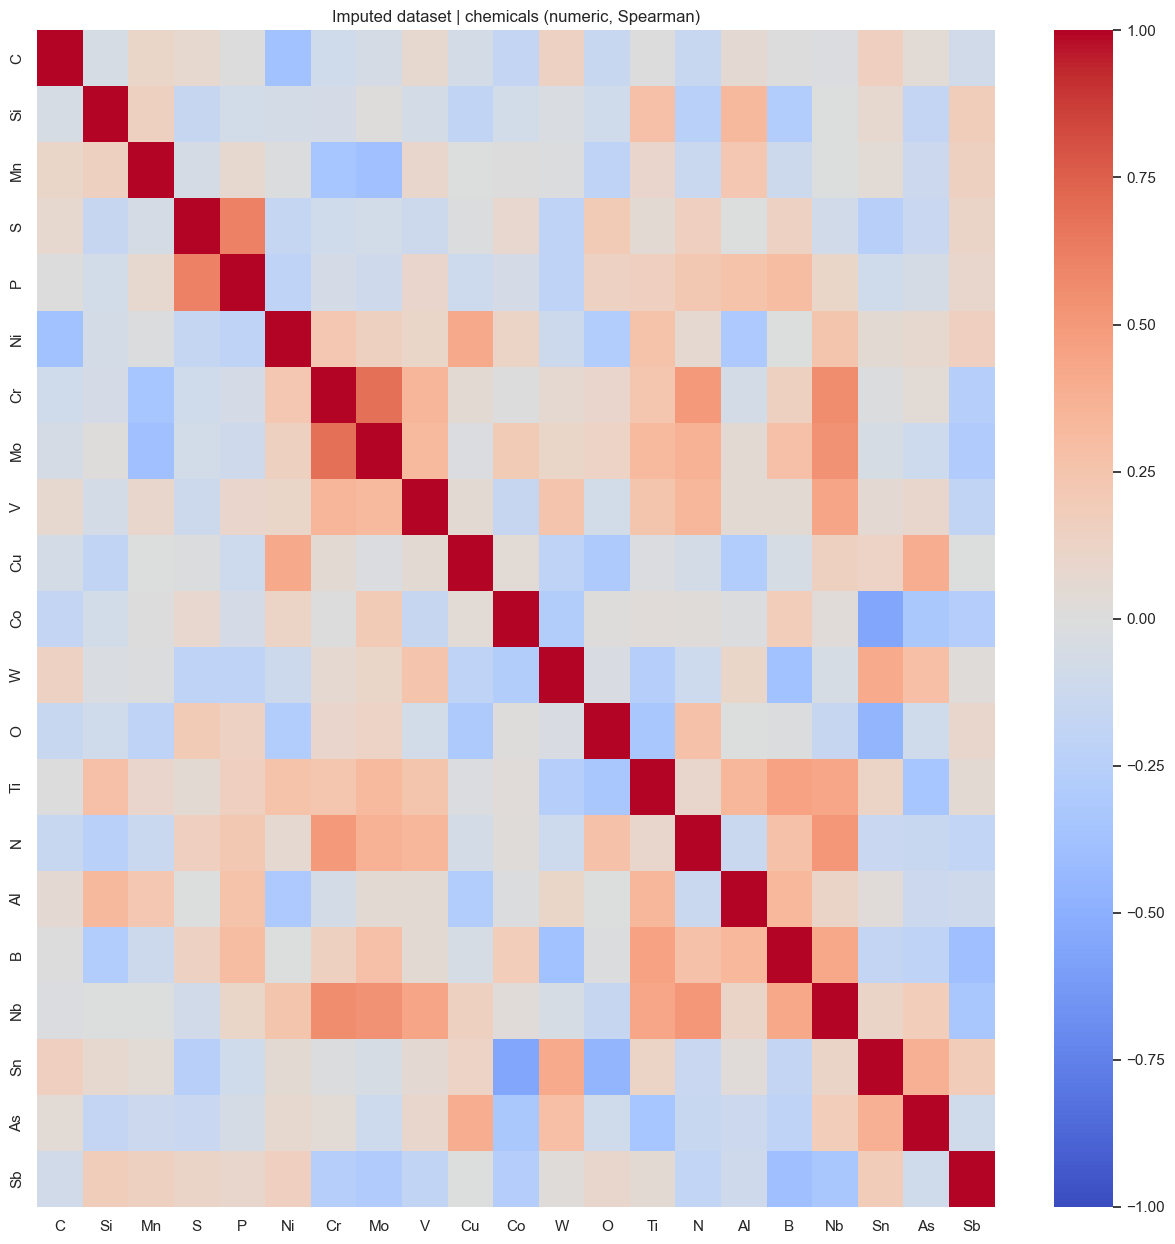

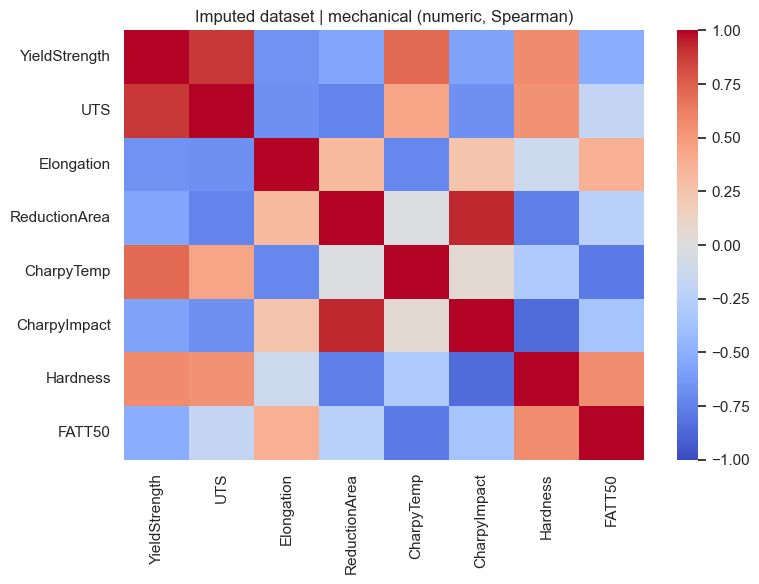

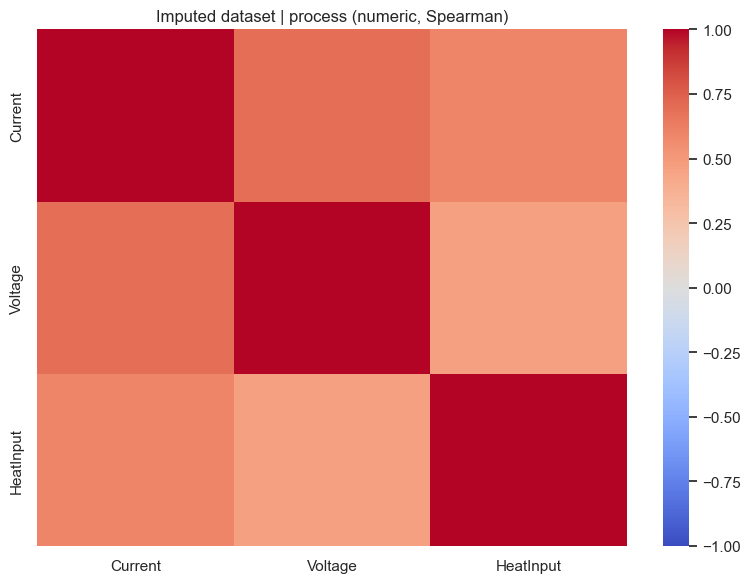

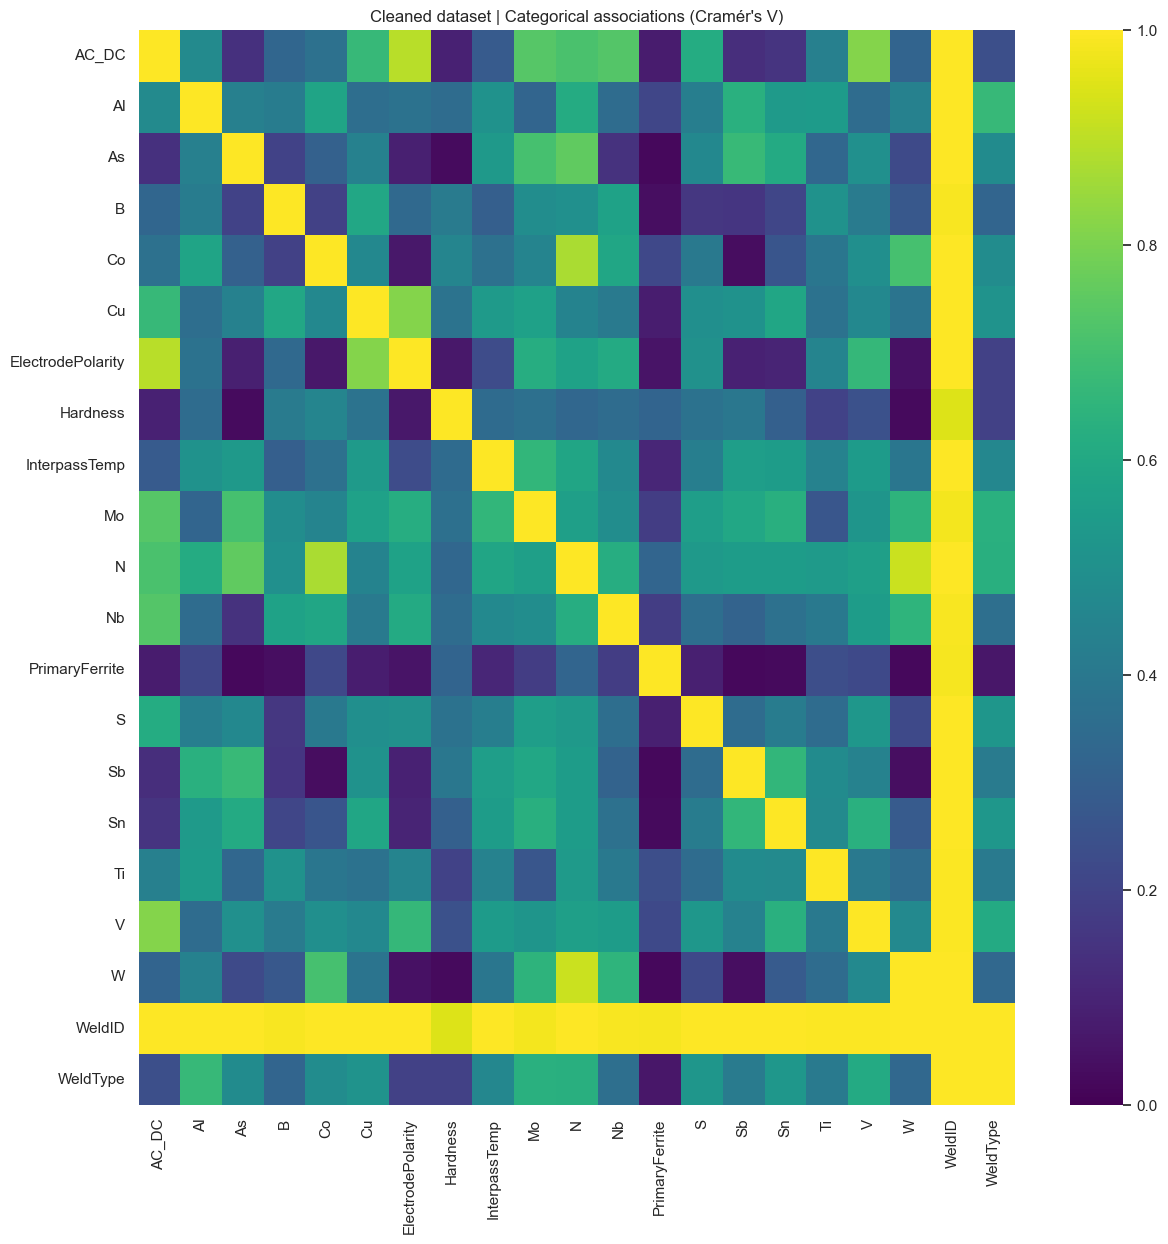

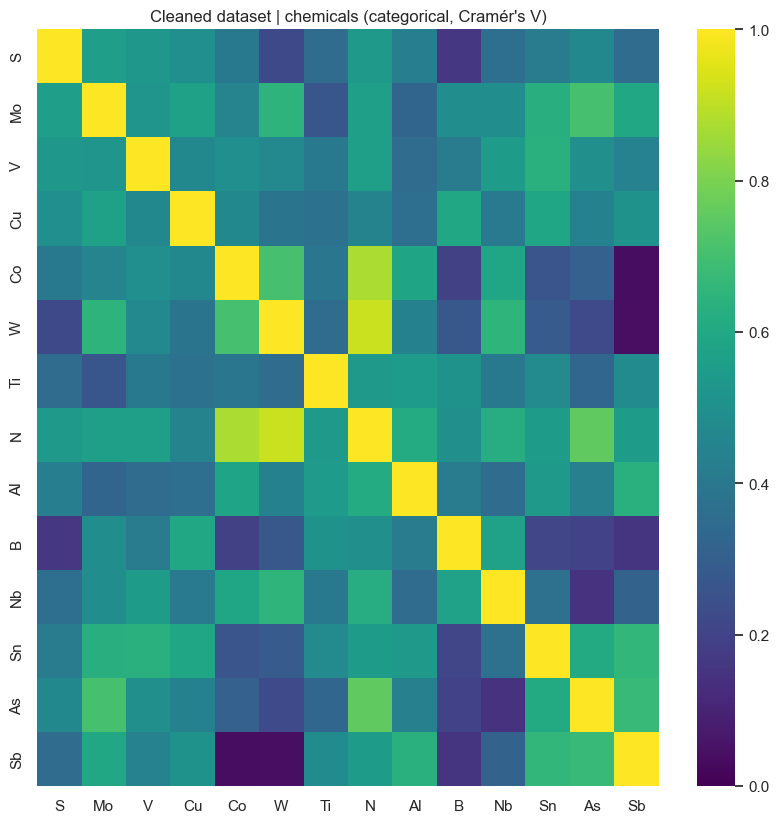

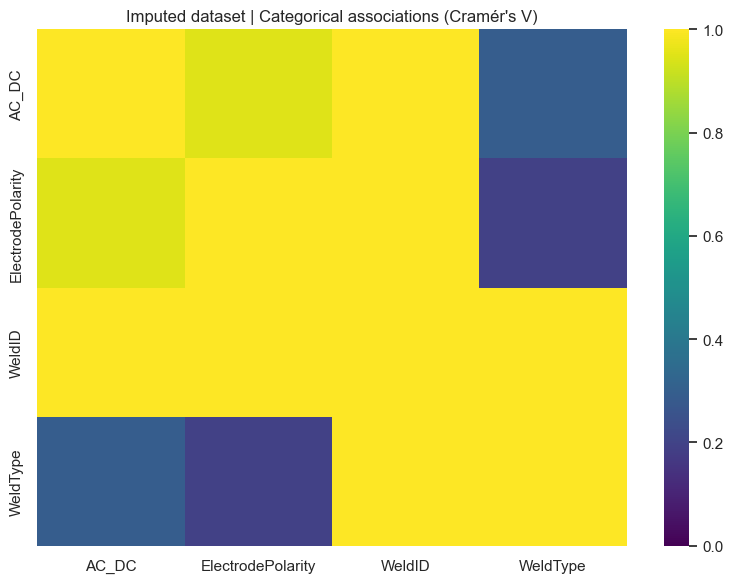

In [5]:
# Correlations: numeric (Pearson/Spearman) and categorical (Cramer's V)

from scipy.stats import chi2_contingency

def cramers_v(confusion_matrix: np.ndarray) -> float:
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    r, k = confusion_matrix.shape
    return np.sqrt((chi2 / n) / (min(k - 1, r - 1) if min(k - 1, r - 1) > 0 else 1))


def categorical_correlation_matrix(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    cols = [c for c in columns if c in df.columns]
    if len(cols) < 2:
        return pd.DataFrame(index=cols, columns=cols)
    mat = pd.DataFrame(index=cols, columns=cols, dtype=float)
    for i, c1 in enumerate(cols):
        for j, c2 in enumerate(cols):
            if j < i:
                continue
            if c1 == c2:
                val = 1.0
            else:
                tbl = pd.crosstab(df[c1].astype(str), df[c2].astype(str))
                if tbl.shape[0] < 2 or tbl.shape[1] < 2:
                    val = np.nan
                else:
                    val = cramers_v(tbl.values)
            mat.loc[c1, c2] = val
            mat.loc[c2, c1] = val
    return mat


def plot_corr_heatmap(corr: pd.DataFrame, title: str, cmap: str = "coolwarm", vmin: float = -1, vmax: float = 1):
    if corr is None or corr.shape[0] == 0:
        return
    plt.figure(figsize=(max(8, corr.shape[1] * 0.6), max(6, corr.shape[0] * 0.6)))
    sns.heatmap(corr, cmap=cmap, vmin=vmin, vmax=vmax, annot=False)
    plt.title(title)
    plt.tight_layout()
    plt.show()


def run_numeric_correlations(df: pd.DataFrame, groups: dict, title: str):
    _, numeric = detect_types(df)
    # Global
    num_cols = [c for c in numeric if c in df.columns]
    if len(num_cols) >= 2:
        corr_pearson = df[num_cols].corr(method='pearson')
        corr_spearman = df[num_cols].corr(method='spearman')
        plot_corr_heatmap(corr_pearson, f"{title} | Numeric correlations (Pearson)")
        plot_corr_heatmap(corr_spearman, f"{title} | Numeric correlations (Spearman)")
    # By group
    for gname, gcols in groups.items():
        gnum = [c for c in gcols if c in num_cols]
        if len(gnum) >= 2:
            corr_g = df[gnum].corr(method='spearman')
            plot_corr_heatmap(corr_g, f"{title} | {gname} (numeric, Spearman)")


def run_categorical_correlations(df: pd.DataFrame, groups: dict, title: str):
    categorical, _ = detect_types(df)
    # Global
    cat_cols = [c for c in categorical if c in df.columns]
    if len(cat_cols) >= 2:
        corr_cat = categorical_correlation_matrix(df, cat_cols)
        plot_corr_heatmap(corr_cat, f"{title} | Categorical associations (Cramér's V)", cmap="viridis", vmin=0, vmax=1)
    # By group
    for gname, gcols in groups.items():
        gcat = [c for c in gcols if c in cat_cols]
        if len(gcat) >= 2:
            corr_g = categorical_correlation_matrix(df, gcat)
            plot_corr_heatmap(corr_g, f"{title} | {gname} (categorical, Cramér's V)", cmap="viridis", vmin=0, vmax=1)

run_numeric_correlations(df_clean, GROUPS_CLEAN, "Cleaned dataset")
run_numeric_correlations(df_imputed, GROUPS_IMPUTED, "Imputed dataset")

run_categorical_correlations(df_clean, GROUPS_CLEAN, "Cleaned dataset")
run_categorical_correlations(df_imputed, GROUPS_IMPUTED, "Imputed dataset")


### Notes de synthèse

- Distinctions effectuées:
  - Variables numériques vs catégorielles détectées automatiquement (types pandas et cardinalité).
  - Groupes de colonnes traités séparément: `chemicals`, `mechanical`, `process`, `metadata`.
- Analyses fournies:
  - Distributions numériques (histogrammes + KDE) et catégorielles (barplots) par groupe pour les deux jeux (cleaned, imputed).
  - Corrélations numériques globales (Pearson/Spearman) et par groupe (Spearman).
  - Associations catégorielles globales et par groupe via Cramér's V.
- À lire:
  - Comparez la dispersion et les modes entre `Cleaned` et `Imputed` pour repérer tout lissage dû à l'imputation (pics plus marqués, queue réduite, etc.).
  - Sur les corrélations, vérifiez si l'imputation renforce/affaiblit certaines relations (changement notable des coefficients).
  - Pour les catégorielles, des hausses de Cramér's V après imputation peuvent indiquer une structure induite par l'imputation.

